<a href="https://colab.research.google.com/github/pendingintent/cdisc-360i-notebooks/blob/main/CDISC_360i_Object_Store_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CDISC 360i: Implementing Standards-Driven Automation Across the Clinical Research Data Lifecycle

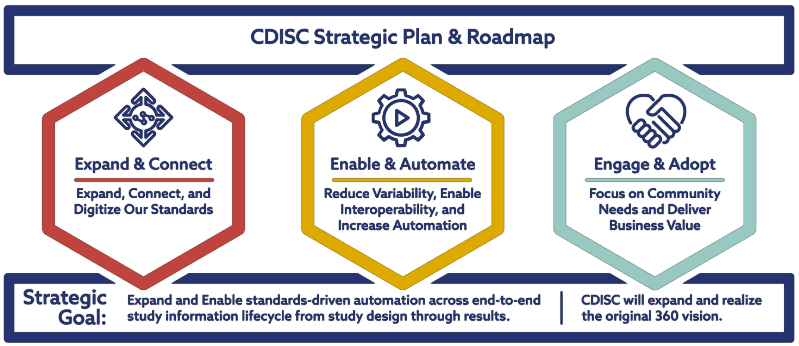

## Abtract

CDISC 360i defines a vision and roadmap to enable standards-driven automation across the clinical research data life cycle - from study design to analysis. The purpose of this paper is to demonstrate the 360i Technical Roadmap by showcasing a strategy for research data pipeline automation using end-to-end, machine-readable standards metadata.

This demonstration will begin by automating study design using concepts and a standardized model to build a digital protocol. Aligned Case Report Forms (CRFs) and SDTM resources will be automatically generated as downstream artifacts using metadata from the digital protocol.




## Operational Data Store (ODS)


This demonstration incorporates the concept of an 'Operational Data Store'.  Data are aggregated and stored centrally to enable data privacy and efficient implementation of operational activities. The ODS acts as a stable foundation for all subsequent data transformation activities.

Raw clinical data can have its source in many different locations and be collected at site, from electronic devices, provisioned electronically by the subjects, sent electronically by central labs, etc.  Data can be transferred in a variety of formats, i.e., FHIR, Dataset-JSON, Dataset-XML, etc.  It is all stored in the ODS.

In practice, an operational data store may consist of a central platform in which collected data extracted from EDC systems and provided by external vendors may be stored and accessed for downstream activities, such as data cleaning and generation of SDTM datasets.

In addition, artifacts such as SDTM datasets may also be stored and accessed to facilitate other downstream activities such ADaM dataset creation. Using an Operational Data Store can centralize the location of all data being used for study assets and allows controlled access, anonymization of subject data and consistent cleaning and transformation of data collected during the study lifecycle.

**Using a shared Google Drive**

In this demonstrartion, Google Drive serves as the Object Store or Operational Data Storage (ODS) for our 360i workflow.

Google Drive shared objects are only available to users with a Google Account and to whom the objects have been shared.
```
from google.colab import drive
drive.mount('/content/drive')

!ls -l drive/MyDrive/resources/
```

## Building a Digital Protocol with USDM

### Digital Protocol USDM

Traditionally, designing a study requires manual management of study-specific artifacts. A study design is extensively documented by researchers in artifacts such as the Study Protocol and Statistical Analysis Plans (SAP). Artifacts to support downstream activities, such as Case Report Forms (CRF) used for data collection, must be aligned with the study design. Today, study design artifacts may be manually prepared, reviewed by different teams, and finalized in isolation. Disconnected artifacts created and maintained through manual processes can lead to content inconsistencies, compromising data traceability and quality, with increased resources needed for routine activities.

CDISC 360i enables a more streamlined and efficient study design process by leveraging the CDISC Unified Study Definitions Model (USDM), Biomedical Concepts (BC), and Controlled Terminology to enable automation and the use of tools to build efficiencies. The goal is to build direct connections between study design artifacts and promote standardized, shared development and management of artifacts across study teams.   

In 360i, study design is centralized through development and mantenance of a digital study protocol. Content within a protocol is standardized per the CDISC USDM. The USDM provides a framework for the structure of protocol content and allows content to be standardized using BCs and Controlled Terminology. The use of standardized concepts and terminology as part of this framework allows concepts and terminologies to be reused via automation across many artifacts ensuring alignment and enhance data traceability and quality.

Two separate solutions have been used to create the USDM JSON study design used for downstream processing in the 360i initiative:

* Study Design Workbench (SDW)
* Open Study Builder (OSB)

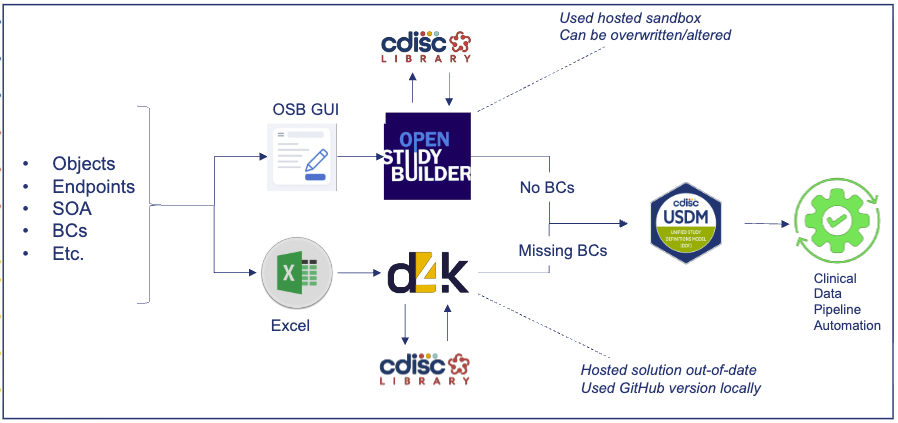

#### Study Definition Workbench (SDW)

*   Open source project can be cloned from GitHub: https://github.com/data4knowledge/study_definitions_workbench
*   Easy-to-use Excel design template

At the time of writing, the SDW is accessed from the web interface: https://d4k-sdw.fly.dev/

The protocol USDM JSON file defines the Schedule of Activities, associates these activities with Biomedical Concepts and becomes the input for downstream 360i processes.




#### OpenStudyBuilder (OSB)

Similarly, the Open Study Builder is an open source project for the creation of clinical study specifications.

The project aims to deliver end-to-end consistency and more efficient processes from protocol development and CRF design through to the creation of data sets for analysis, reporting and submission.

The OSB includes the web-based interface, the Metadata Repository for all study specification data, and an API layer enabling the integration with other source and target systems.

Additional information on accessing the online environment or hosting an instance locally is available here: https://www.openstudybuilder.com/

The project source code is freely available for download or contribution: https://gitlab.com/Novo-Nordisk/nn-public/openstudybuilder/OpenStudyBuilder-Solution


### USDM JSON

The study design XLSX template has been used in the ***Study Definition Workbench*** to create a version 4 USDM JSON document adhering to the standards defined in the USDM implementation guide.

This digital protocol serves as the input for all downstream processes.

The assets for the example protocol used throughout this notebook are freely available on github: https://github.com/cdisc-org/360i/tree/main/data/protocol/LZZT/usdm


#### Creating and Validating the USDM Study Design

**Configure the environment to be used throughout automation**

This includes the installation of dependencies, setting of variables, definition of functions, etc.

In [1]:
# @title
# Debug statements
#!which python
#!python --version

# Install Dependencies
!pip install -q requests cairosvg validators pathvalidate saxonche click xmlschema dominate
!apt-get install -y libxml2-utils

# Import modules
import os
import urllib
from urllib.parse import urlparse
from google.colab import files, userdata, drive
from IPython.core.display import display, JSON, HTML
import subprocess
import shutil
import json
import pandas as pd
import requests
import io
import pygame
import cairosvg
import PIL.Image
from google.colab import drive

# Define functions
def change_working_dir(working_dir):
    pwd = os.getcwd()

    if pwd == working_dir:
        print("INFO: Already in the {} project directory...".format(working_dir))
    else:
        print("INFO: Changing to the {} working directory...".format(working_dir))
        try:
            os.chdir(working_dir)
        except FileNotFoundError:
            print("ERROR: {} does not exist...".format(working_dir))

def render_svg(svg_data, scale):
    svg_data = cairosvg.svg2svg(svg_data, dpi=(96 / scale))
    png_data = cairosvg.svg2png(svg_data)
    byte_io = io.BytesIO(png_data)
    return pygame.image.load(byte_io)

def create_dir(target_dir):
    # requires import os
    if os.path.exists(target_dir):
        print("INFO: {} exists...".format(target_dir))
    else:
        print("INFO: Creating directory {}...".format(target_dir))
        os.mkdir(target_dir)

# Mount the object store
drive.mount('/content/drive')



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libxml2-utils is already the newest version (2.9.13+dfsg-1ubuntu0.9).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
pygame 2.6.1 (SDL 2.28.4, Python 3.12.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Expanding/unhiding the code in the cell above, will show how the notebook is configured prior to cloning and execution of the open-source projects used in demonstrating the end-to-end automation in the 360i initiative.

Create the study directory in the Object Store Trial Master File.

In [2]:
# @title
# Get name for the study in TMF
study_name = input \
 ("Enter the name of the study to be used in the Trial Master File: ")

# Define global variables
CONTENT_DIR = os.path.join('/content/drive/MyDrive/TMF')
STUDY_DIR = os.path.join(CONTENT_DIR, study_name.upper())
PROTOCOL_DIR = os.path.join(STUDY_DIR, 'protocol')
DATASET_DIR = os.path.join(STUDY_DIR, 'datasets')
CRF_DIR = os.path.join(STUDY_DIR, 'crf')
REPORT_DIR = os.path.join(STUDY_DIR, 'reports')
CLINICAL_DIR = os.path.join(STUDY_DIR, 'clinical_data')
DATABASE_DIR = os.path.join(STUDY_DIR, 'clinical_database')
SHELL_DIR = os.path.join(STUDY_DIR, 'shell_datasets')

TMF_DIRS = [STUDY_DIR, DATASET_DIR, PROTOCOL_DIR, CRF_DIR, REPORT_DIR,
                CLINICAL_DIR, DATABASE_DIR, SHELL_DIR]

WORKING_DIR = '/content'
WORKING_DIRS = []

# Create directories, if required
change_working_dir(CONTENT_DIR)
for dir in TMF_DIRS:
  create_dir(dir)

Enter the name of the study to be used in the Trial Master File: H2Q-MC-LZZT
INFO: Changing to the /content/drive/MyDrive/TMF working directory...
INFO: /content/drive/MyDrive/TMF/H2Q-MC-LZZT exists...
INFO: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets exists...
INFO: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/protocol exists...
INFO: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/crf exists...
INFO: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/reports exists...
INFO: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/clinical_data exists...
INFO: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/clinical_database exists...
INFO: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/shell_datasets exists...


**Clone validation utility repository**

For the validation of the USDM JSON file to ensure compliance with the USDM v4.0 schema, an open-source utility is cloned and used to validate the structure.

In [3]:
# @title
# Clone the GitHub repository that contains the validation utility

change_working_dir(WORKING_DIR)
repo = 'https://github.com/pendingintent/cdisc-json-validation'
!git clone {repo}
project = urlparse(repo)[2]
validation_dir = project[project.rindex('/')+1:len(project)]
WORKING_DIRS.append(os.path.join(WORKING_DIR, validation_dir))
change_working_dir(validation_dir)

INFO: Changing to the /content working directory...
Cloning into 'cdisc-json-validation'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 85 (delta 39), reused 61 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 1.26 MiB | 4.96 MiB/s, done.
Resolving deltas: 100% (39/39), done.
INFO: Changing to the cdisc-json-validation working directory...


This is one of many utilities developed and shared within the open-source community to help facilitate the 360i vision.

Upload the Study Design workbook used to define the study and from which the USDM JSON file is created

The Study Design Workbook can be downloaded: https://github.com/cdisc-org/360i/blob/main/data/protocol/LZZT/usdm/pilot_LLZT_protocol.xlsx

Examine the study design workbook to examine the study Schedule of Activities by viewing the **mainTimeline** worksheet.

In [6]:
# @title
# Upload the study design workbook file

change_working_dir(PROTOCOL_DIR)
uploaded = files.upload()
xlsx_file_name = list(uploaded)[0]
xlsx_file_path = os.path.join(PROTOCOL_DIR, xlsx_file_name)
print(xlsx_file_path)

INFO: Already in the /content/drive/MyDrive/TMF/H2Q-MC-LZZT/protocol project directory...


Saving pilot_LLZT_protocol.xlsx to pilot_LLZT_protocol.xlsx
/content/drive/MyDrive/TMF/H2Q-MC-LZZT/protocol/pilot_LLZT_protocol.xlsx


The Study Design Workbook is an XLSX file defining the study Schedule of Activities as well as other study properties and metadata required in the USDM JSON Study Design.

Once uploaded to the working directory and Operational Data Store, this file can be versioned and serves as the source definition for the study when used in the Study Definition Workbench to create the USDM JSON study definition.

**View the schedule of activities and associcated Biomedical Concepts**

In [7]:
# @title
# View the mainTimeline worksheet

df = pd.read_excel(xlsx_file_path, sheet_name='mainTimeline')
display(df)

Name                                    Main Timeline  \
0       Description  This is the main timeline for the study design.   
1         Condition                     Potential subject identified   
2               NaN                                              NaN   
3               NaN                                              NaN   
4               NaN                                              NaN   
5               NaN                                              NaN   
6               NaN                                              NaN   
7   Parent Activity                                   Child Activity   
8               NaN                                 Informed consent   
9               NaN                     Inclusion/exclusion criteria   
10              NaN                          Patient number assigned   
11              NaN                                     Demographics   
12              NaN                                        Education   
13              NaN                                        Hachinski   
14              NaN                                             MMSE   
15              NaN                             Physical examination   
16              NaN                                  Medical history   
17              NaN                                           Habits   
18              NaN                                      Chest X-ray   
19              NaN                                 Apo E genotyping   
20              NaN                               Patient randomised   
21              NaN                        Vital signs / Temperature   
22              NaN                            Ambulatory ECG placed   
23              NaN                           Ambulatory ECG removed   
24              NaN                                              ECG   
25              NaN                                 Placebo TTS test   
26              NaN                                          CT scan   
27              NaN                                              MRI   
28              NaN                                     MRI, CT Scan   
29              NaN                          Concomitant medications   
30              NaN                                       Hematology   
31              NaN                                        Chemistry   
32              NaN                                       Urinalysis   
33              NaN                     Plasma Specimen (Xanomeline)   
34              NaN                                   Hemoglobin A1C   
35              NaN                                       Study drug   
36              NaN                         TTS Acceptability Survey   
37              NaN                                         ADAS-Cog   
38              NaN                                           CIBIC+   
39              NaN                                              DAD   
40              NaN                                            NPI-X   

                                                 name     SCREEN1     SCREEN2  \
0                                         description           -           -   
1                                               label  Screen One  Screen Two   
2                                                type    Activity    Activity   
3                                             default     SCREEN2        DOSE   
4                                           condition         NaN         NaN   
5                                               epoch   Screening   Screening   
6                                           encounter          E1          E2   
7                               BC/Procedure/Timeline         NaN         NaN   
8                                 BC:Informed Consent           X           -   
9   BC: Inclusion Exclusion Criteria Yes No Indica...           X           -   
10                           BC:Subject is Randomized           X           -   
11  BC:Sex, BC:Rac

The **Schedule of Activities** is defined in the study design template for the LZZT Pilot study. The SoA includes Biomedical Concepts for Procedures used during a subject journey through the study timeline.

In the table above, the study Schedule of Activities is clear and the Biomedical Concepts defining the Procedures scheduled for each activity and across visits can be seen.

**Row 21** displays the Biomedical Concepts for Vital Signs.  These Biomedical Concepts (BCs) will be used to aid in the automation of Case Report Form creation and annotation.

It is from this XLSX document that the USDM JSON file is created using the **Study Defition Workbench**.

**Select the USDM JSON file created using the Study Definitions Workbench**

Once the study has been defined in the Workbook above, it is loaded into the Study Definition Workbench to create the USDM JSON study definition.

The JSON file will be uploaded into the working directory and Operational Data Store.

In [8]:
# @title
# Upload the study defition USDM JSON file

change_working_dir(PROTOCOL_DIR)
uploaded = files.upload()
usdm_file_name = list(uploaded)[0]
usdm_file_path = os.path.join(PROTOCOL_DIR, usdm_file_name)
print(usdm_file_path)


INFO: Already in the /content/drive/MyDrive/TMF/H2Q-MC-LZZT/protocol project directory...


Saving pilot_LLZT_protocol.json to pilot_LLZT_protocol.json
/content/drive/MyDrive/TMF/H2Q-MC-LZZT/protocol/pilot_LLZT_protocol.json


Now that the JSON file has been uploaded into the environment, it can be used for further downstream processing.

**View the uploaded JSON file**

In [9]:
# @title
# View uploaded files

with open(usdm_file_path, 'r') as f:
    usdm_data = json.load(f)
display(JSON(usdm_data))

<IPython.core.display.JSON object>



Quick analysis of the JSON file identifies the JSON document as a USDM v4 design document.

"usdmVersion": "4.0.0"

In order to ensure compliance with the USDM V4.0 standard, the open-source utility cloned earlier can be used.

**Validate the JSON file using the utility**

In a previous step, an open-source USDM validation utility was cloned.  This utility can be used to validate the USDM study definition against the v4.0 JSON schema.

In [10]:
# @title
# Validate the USDM JSON v4

change_working_dir(os.path.join(WORKING_DIR, validation_dir))
print("INFO: Validating {}...".format(usdm_file_path))
result = subprocess.run(["python", "validate.py", usdm_file_path], capture_output=True, text=True)
if "Validation successful" not in result.stdout:
    print("ERROR: Validation of {} not successful...".format(usdm_file_path))
else:
    print("INFO: Validation of {} is successful...".format(usdm_file_path))


INFO: Changing to the /content/cdisc-json-validation working directory...
INFO: Validating /content/drive/MyDrive/TMF/H2Q-MC-LZZT/protocol/pilot_LLZT_protocol.json...
INFO: Validation of /content/drive/MyDrive/TMF/H2Q-MC-LZZT/protocol/pilot_LLZT_protocol.json is successful...


The newly uploaded JSON file validates against the version 4.0 USDM JSON schema.

**Validate the JSON file using CDISC Rules Engine**

Although the USDM JSON file validates against the schema, more detailed validation is required.  This is where the CDISC Conformance Rules Engine can validate the USDM JSON stduy definition.

The CDISC Conformance Rules (**CORE**) serve as guidance for the industry on the correct implementation of Standards in Clinical Trials.  These conformance rules can be used throughout the study lifecycle to ensure conformance with the standards ensuring the data is as close to submission-ready as possible.

The CDISC rules engine is an open-source project designed for validating clinical trial data against CDISC Conformance Rules as well as any custom conformance rules defined by the user.

Conformance Rules are under constant development and are all included in the CDISC Library.

Additional information on the Conformance Rules is included later in this notebook

More information is available at: https://www.cdisc.org/core

**Install the CDISC CORE Rules Engine**

A platform-specific release was created for the CORE engine to function in this target environment.  The Google Colab environment runs on Ubuntu 22.04.4 LTS.  This version uses specific versions of libraries and, therefore, a platform-specific release for the CDISC Rules engine is required.

If a platform-specific release is required to meet dependency or platform requirements, instructions are available in the project: https://github.com/cdisc-org/cdisc-rules-engine/blob/main/README_Build_Executable.md

In [11]:
# @title
# A specific release has been created for this environment and will
# be copied from object storage.

change_working_dir(WORKING_DIR)
src = os.path.join(CONTENT_DIR, 'core.tar.gz')
if os.path.exists(src):
  shutil.copy2(src, WORKING_DIR)
  !tar -zxf 'core.tar.gz'> /dev/null 2>&1
  WORKING_DIRS.append(os.path.join(WORKING_DIR, 'core'))
  change_working_dir('core')
  !chmod +x ./core
else:
  print("ERROR: {} does not exist...".format(src))


INFO: Changing to the /content working directory...
INFO: Changing to the core working directory...


Once extracted, the CORE engine rules local cache can be updated.  In order to update the local CORE engine rules cache, the environmental parameter CDISC_API_KEY must exist.

Use the command `python core.py update-cache`

**Use the CDISC Rules Engine to validate the USDM JSON file against the Conformance Rules from the CDISC Library**

All of the CDISC Library Conformance Rules for USDM v4.0 will be executed against the USDM JSON study design file.

For additional information on how to execute the CORE validation rules and the options that are available, consult the README: https://github.com/cdisc-org/cdisc-rules-engine

In [12]:
# @title
# Validate the USDM JSON file against the USDM version 4 Conformance Rules

destination_path = os.path.join(REPORT_DIR, 'usdm_validation_results')
print("INFO: Validating {} with the USDM v4 Conformance Rules...".format(usdm_file_path))
!./core validate -s USDM -v 4-0 -o {destination_path} -dp {usdm_file_path}

INFO: Validating /content/drive/MyDrive/TMF/H2Q-MC-LZZT/protocol/pilot_LLZT_protocol.json with the USDM v4 Conformance Rules...
pkg_resources/__init__.py:2211: UserWarning: /content/core/._cryptography-3.4.8.egg-info could not be properly decoded in UTF-8
pkg_resources/__init__.py:2211: UserWarning: /content/core/._wheel-0.37.1.egg-info could not be properly decoded in UTF-8
  [████████████████████████████████████]  100%
Output: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/reports/usdm_validation_results


**View the Rules Report list of USDM core tests executed**

A comprehensive **Conformance Report** is created as an Excel Workbook.

In [13]:
# @title
# Create a pandas dataframe to view the Rules Report worksheet in the report
# produced by the CORE Engine

results_file = destination_path + '.xlsx'
df = pd.read_excel(results_file, sheet_name='Rules Report')
display(df)

CORE-ID  Version CDISC RuleID  FDA RuleID  \
0           NaN        1     DDF00156         NaN   
1   CORE-000402        1     DDF00006         NaN   
2   CORE-000403        1     DDF00007         NaN   
3   CORE-000404        1     DDF00008         NaN   
4   CORE-000408        1     DDF00013         NaN   
5   CORE-000414        1     DDF00021         NaN   
6   CORE-000416        1     DDF00023         NaN   
7   CORE-000417        1     DDF00025         NaN   
8   CORE-000419        1     DDF00027         NaN   
9   CORE-000423        1     DDF00031         NaN   
10  CORE-000424        1     DDF00032         NaN   
11  CORE-000427        1     DDF00035         NaN   
12  CORE-000428        1     DDF00036         NaN   
13  CORE-000449        1     DDF00040         NaN   
14  CORE-000804        1     DDF00046         NaN   
15  CORE-000805        1     DDF00042         NaN   
16  CORE-000806        1     DDF00017         NaN   
17  CORE-000807        1     DDF00037         NaN   
18  CORE-000808        1     DDF00073         NaN   
19  CORE-000809        1     DDF00047         NaN   
20  CORE-000810        1     DDF00075         NaN   
21  CORE-000811        1     DDF00090         NaN   
22  CORE-000812        1     DDF00014         NaN   
23  CORE-000813        1     DDF00052         NaN   
24  CORE-000814        1     DDF00094         NaN   
25  CORE-000815        1     DDF00097         NaN   
26  CORE-000816        1     DDF00099         NaN   
27  CORE-000817        1     DDF00100         NaN   
28  CORE-000818        1     DDF00026         NaN   
29  CORE-000819        1     DDF00102         NaN   
30  CORE-000820        1     DDF00060         NaN   
31  CORE-000821        1     DDF00044         NaN   
32  CORE-000822        1     DDF00108         NaN   
33  CORE-000823        1     DDF00115         NaN   
34  CORE-000824        1     DDF00019         NaN   
35  CORE-000825        1     DDF00061         NaN   
36  CORE-000826        1     DDF00062         NaN   
37  CORE-000827        1     DDF00127         NaN   
38  CORE-000828        1     DDF00063         NaN   
39  CORE-000829        1     DDF00054         NaN   
40  CORE-000830        1     DDF00011         NaN   
41  CORE-000831        1     DDF00058         NaN   
42  CORE-000832        1     DDF00059         NaN   
43  CORE-000833        1     DDF00137         NaN   
44  CORE-000834        1     DDF00151         NaN   
45  CORE-000835        1     DDF00071         NaN   
46  CORE-000836        1     DDF00072         NaN   
47  CORE-000837        1     DDF00028         NaN   
48  CORE-000838        1     DDF00029         NaN   
49  CORE-000839        1     DDF00024         NaN   
50  CORE-000840        1     DDF00152         NaN   
51  CORE-000849        1     DDF00022         NaN   
52  CORE-000851        1     DDF00018         NaN   

                                              Message   Status  
0   The environmental settings of the encounter ar...  SUCCESS  
1   One or more of the window attributes (windowLa...  SUCCESS  
2   The Timing type is "Fixed Reference" but it do...  SUCCESS  
3   The defaultConditionId and timelineExitId attr...  SUCCESS  
4   A required biomedical concept property (isRequ...  SUCCESS  
5   An instance of a class is referencing itself a...  SUCCESS  
6   The next and previous relationships are not re...  SUCCESS  
7   One or more of the window attributes (windowLa...  SUCCESS  
8   The same instance is referenced more than once...  SUCCESS  
9   The Timing type is not "Fixed Reference" but i...  SUCCESS  
10  The business therapeutic areas of the study ve...  SUCCESS  
11  There is not a one-to-one relationship between...  SUCCESS  
12  Type is "Fixed Reference" for the timing but r...  SUCCESS  
13  The study element is not referenced by any stu...  SUCCESS  
14  The relative to/from scheduled instance of a t...  SUCCESS  
15  The planned age range is marked as approximate...  SUCCESS  
16  The unit for a subject enrollement q

This report worksheet lists all of the conformance rules run to validate the USDM JSON file adn whether the execution was successful.

**View the Issue Sumary produced by the CORE Engine**

The Conformance Report contains details for each of the conformance tests and results.

In [14]:
# @title
# Create a pandas dataframe to view the Issue Summary worksheet in the report
# produced by the CORE Engine

df = pd.read_excel(results_file, sheet_name='Issue Summary')
display(df)

Dataset      CORE-ID  \
0  Activity.json  CORE-000810   
1      Code.json  CORE-000427   

                                             Message  Issues  Explanation  
0  The activity does not refer to any procedure, ...      12          NaN  
1  There is not a one-to-one relationship between...      38          NaN

This report worksheet summarizes any issues identified during validation of hte USDM JSON file.

The report identifies two conformance rules for which issues were identified in the JSON file:

 * CORE-000810
 * CORE-000427

At this point, a USDM JSON file has been created from the study design workbook file using the Study Definition Workbench.

The JSON file format is then validated against the USDM JSON
version 4 schema.

The CORE Engine is then used to execute the USDM v4.0 Conformance Rules from the CDISC Library against the USDM JSON file .



---



### OpenStudyBuilder (OSB)



*In order to execute the Open Study Builder API demonstration cells below, the session must use a valid Bearer Token.  If the user executing this notebook does not have access to the OSB environment or does not know how to include a valid Bearer Token in this session, skip this section.*

**Set bearer token**

The Open Study Builder requires authorization. Using OAuth2 requires manual intervention in the browser to retrieve the CODE value generated for authorization.

Similarly, the bearer token can be retrieved from the request header using the browser Developer Tools from an authorized Open Study Builder session.

The bearer token has a relatively short TTL and will need to be updated (at least) once a session.

In [95]:
# @title
# The bearer token can be entered as an environmental variable
# or stored in the Colab secrets or promnpt the user

# bearer_token = userdata.get('OSB_BEARER_TOKEN')
bearer_token = input("Enter the OSB Bearer Token: ")

Enter the OSB Bearer Token: 


**Retrieve the study USDM JSON file from the OSB API**

The JSON text can be stored in a variable or written to a file and added to object storage.

In [17]:
# @title
# Get USDM JSON from OSB study
# Hard-coded URL for the OpenStudyBuilder Sandbox instance.
study_uid = 'Study_000016'
url = 'https://openstudybuilder.northeurope.cloudapp.azure.com/api/usdm/v3/studyDefinitions/' + study_uid
headers = {
    'Authorization': 'Bearer ' + bearer_token,
    'Content-Type': 'application/json'
}

try:
  response = requests.get(url, headers=headers)
  response.raise_for_status()
  data = response.json()
  display(JSON(data))
except requests.exceptions.RequestException as e:
  print("Error: {}".format(e))
  print("Status Code: {}".format(response.status_code if response else "N/A"))
  print("Response Body: {}".format(response.text if response else "N/A"))


<IPython.core.display.JSON object>

The USDM JSON document for a study defined in the OSB can be accessed through the API for validation and use in downstream automation.

**Use the API to get study properties**

In [18]:
# @title
# Get basic study properties

headers = {
    'Authorization': f'Bearer {bearer_token}',
    'Content-Type': 'application/json'
}

url = 'https://openstudybuilder.northeurope.cloudapp.azure.com/api/studies/Study_000016?ignoreErrors=true&study_value_version=4'

try:
  response = requests.get(url, headers=headers)
  json_data = response.json()
  print('Study Name: {}'.format(json_data['current_metadata']['identification_metadata']['study_id']))
  print('Study UID: {}'.format(json_data['uid']))
  print('Description: {}'.format(json_data['current_metadata']['study_description']['study_title']))
  print('Version: {}'.format(json_data['current_metadata']['version_metadata']['version_number']))
  print('Author: {}'.format(json_data['current_metadata']['version_metadata']['version_author']))
except requests.exceptions.RequestException as e:
  print("Error: {}".format(e))
  print("Status Code: {}".format(response.status_code if response else "N/A"))
  print("Response Body: {}".format(response.text if response else "N/A"))


Study Name: CDISC DEV-6708
Study UID: Study_000016
Description: Safety and Efficacy of the Test Product Transdermal Therapeutic System TSS in Patients with Mild to Moderate Alzheimer's Disease
Version: 4
Author: katja.glass@glacon.eu


**Get the Study Schema**

The purpose of the Study Schema is to provide a visual depiction of the trial design, orienting users of the protocol to the key features of the design. The schema displays the trial arms, the flow of individual participants through the progression of trial period(s)/epochs (such as screening, washout/run-in, intervention, and key milestones [for example, randomization, cross-over, end of treatment]).

200


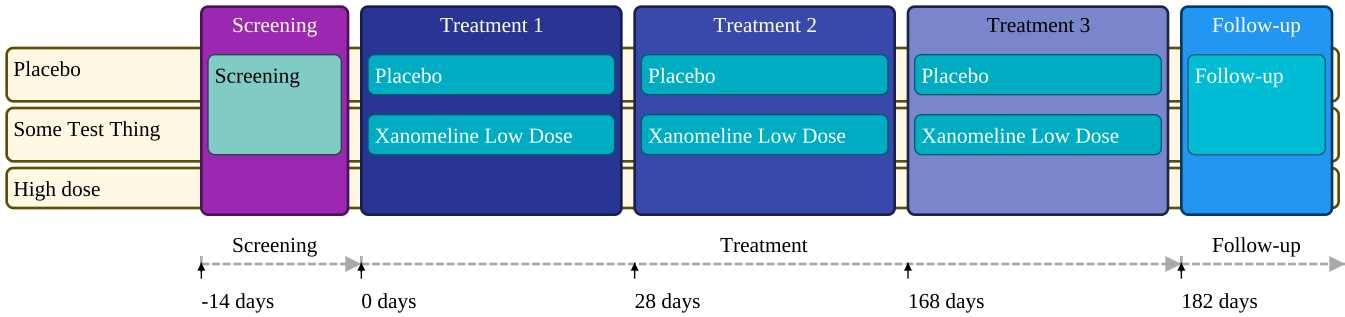

In [19]:
# @title
# Use the API to return the study schema from OSB
headers = {'Authorization': f'Bearer {bearer_token}'}
url = 'https://openstudybuilder.northeurope.cloudapp.azure.com/api/studies/Study_000016/design.svg?study_value_version=4'

try:
  response = requests.get(url, headers=headers)
  print(response.status_code)

  # Check if the response is an SVG image
  if 'image/svg+xml' in response.headers.get('Content-Type', ''):
      svg_content = response.text
      image = render_svg(svg_content, 1)

      pil_image = PIL.Image.frombytes("RGBA", image.get_size(), image.get_buffer().raw)

      display(pil_image)
  else:
      print("The response is not an SVG image.")
      print(response.text)
except requests.exceptions.RequestException as e:
  print("Error: {}".format(e))
  print("Status Code: {}".format(response.status_code if response else "N/A"))
  print("Response Body: {}".format(response.text if response else "N/A"))


**Display the Protocol Operational SoA**

The Schedule of Activities can be retrieved through the OSB APIs.

In [20]:
# @title
# Use the api to return the Schedule of Activities from OSB
headers = {'Authorization': f'Bearer {bearer_token}'}
url = 'https://openstudybuilder.northeurope.cloudapp.azure.com/api/studies/Study_000016/flowchart.html?layout=protocol&study_value_version=4'

try:
  response = requests.get(url, headers=headers)
  print(response.status_code)
  display(HTML(response.text))
except requests.exceptions.RequestException as e:
  print("Error: {}".format(e))
  print("Status Code: {}".format(response.status_code if response else "N/A"))
  print("Response Body: {}".format(response.text if response else "N/A"))


200


**Display the ICH M11 Template for the study**

The alignment of the USDM standard with the ICM M11 CeShaRP supports the automated propulation of the M11 Template with objects defined in the USDM resulting in the creation of a digital protocol document.

In [21]:
# @title
# Use the api to return the populated ICM M11 template
headers = {'Authorization': f'Bearer {bearer_token}'}
url = "https://openstudybuilder.northeurope.cloudapp.azure.com/api/usdm/v3/studyDefinitions/Study_000016/m11"

try:
  response = requests.get(url, headers=headers)
  print(response.status_code)
  display(HTML(response.text))
except requests.exceptions.RequestException as e:
  print("Error: {}".format(e))
  print("Status Code: {}".format(response.status_code if response else "N/A"))
  print("Response Body: {}".format(response.text if response else "N/A"))


200


Scroll to Section 1.3 to view the Schedule of Activities for the Study.  

**The OSB offers a comprehensive collection of APIs that enable discovery of study design objects.**

For more information on available OSB APIs, please refer to https://openstudybuilder.northeurope.cloudapp.azure.com/api/docs



---



## Case Report Forms and Form Annotation

### Electronic Case Report Forms

CDISC 360i uses study design elements maintained in the digital protocol with standard metadata to automate the design of electronic case report forms (eCRFs) data collection artifacts. Automation significantly reduces the time and effort required for CRF development and configuration and improves the quality and consistency of eCRFs by minimizing manual design and configuration errors. It ensures better adherence to CDISC standards and facilitates faster data collection setup.





### Annotated Case Report Forms (aCRF)

Automating the creation of aCRF from the study design phase drastically reduces the time taken to manually annotate the CRFs.  These annotated CRFs serve as the input from which the CRF designs are generated.

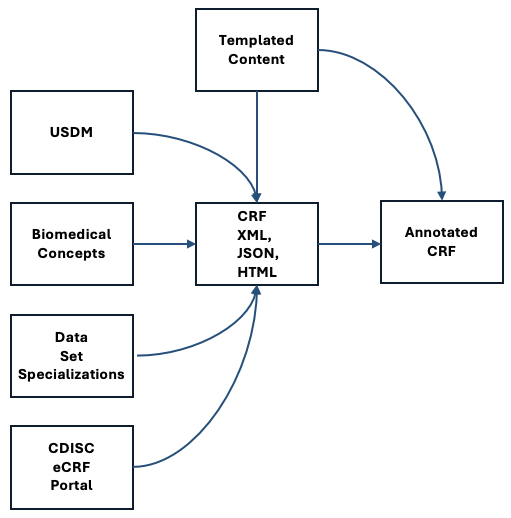

**Clone the repository containing the required utilities**

An open-source solution has been developed to facilitate the automated creation and annotation of the Case Report Forms in easy to display HTML as well as ODM XML and JSON dataset transformation compliant formats.

Clone the GitHub repository: https://github.com/lexjansen/cdisc360i-pocs.git


In [22]:
# @title
# Clone the GitHub repository that contains the validation utility

change_working_dir(WORKING_DIR)
repo = 'https://github.com/lexjansen/cdisc360i-pocs'
!git clone {repo}
project = urlparse(repo)[2]
working_dir = os.path.join(
    WORKING_DIR, project[project.rindex('/')+1:len(project)])
WORKING_DIRS.append(working_dir)
change_working_dir(working_dir)
# Include the uninstall of ODMLIB to ensure there are no conflicting libraries
!pip uninstall -y odmlib

INFO: Changing to the /content working directory...
Cloning into 'cdisc360i-pocs'...
remote: Enumerating objects: 1229, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 1229 (delta 70), reused 121 (delta 40), pack-reused 1057 (from 1)
Receiving objects: 100% (1229/1229), 5.22 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (901/901), done.
INFO: Changing to the /content/cdisc360i-pocs working directory...
Found existing installation: odmlib 0.1.4
Uninstalling odmlib-0.1.4:
  Successfully uninstalled odmlib-0.1.4


**Generate the anotated Case Report Forms and the Case Report Forms for data entry**

Execution of the utility will create an HTML version of the CRF, an HTML version of the annotated CRF, a JSON representation and an XML representation of the CRF.


In [23]:
# Generate ODM XML v2.0 XML, CRFs in HTML, and annotated HTML CRFs for Vital Signs
%%python ./bc_dss2crf/cdash_poc_odm20.py -f VS1 -p vital_signs

2025-10-01 17:48:49 - INFO - VS_01 - Vital Signs Performed - VSPERF - C82525
2025-10-01 17:48:49 - INFO - VS_02 - Vital Signs - SYSBP_DENORMALIZED - C25298
2025-10-01 17:48:49 - INFO - VS_02 - Vital Signs - DIABP_DENORMALIZED - C25299
2025-10-01 17:48:49 - INFO - VS_02 - Vital Signs - HEIGHT_DENORMALIZED - C164634
2025-10-01 17:48:49 - INFO - VS_02 - Vital Signs - WEIGHT_DENORMALIZED - C81328
2025-10-01 17:48:49 - INFO - VS_02 - Vital Signs - BMI_DENORMALIZED - C16358
2025-10-01 17:48:49 - INFO - VS_02 - Vital Signs - PULSE_DENORMALIZED - C49676
2025-10-01 17:48:49 - INFO - VS_02 - Vital Signs - RESP_DENORMALIZED - C49678
2025-10-01 17:48:49 - INFO - VS_02 - Vital Signs - TEMP_DENORMALIZED - C174446
2025-10-01 17:48:49 - INFO - VS_02 - Vital Signs - HR_DENORMALIZED - C49677
2025-10-01 17:48:49 - INFO - Directory 'crf/VS1' will be created.
2025-10-01 17:48:52 - INFO - ODM XML schema validation completed successfully...
2025-10-01 17:48:52 - INFO - Saxon-HE version: SaxonC-HE 12.9 from S

In [24]:
# @title
# Move and rename CRF files

for file in os.listdir('crf/VS1'):
  print("INFO: Copying {} to {}...".format(file, CRF_DIR))
  shutil.copy2(os.path.join('crf/VS1', file), CRF_DIR)

INFO: Copying vital_signs_odmv2-0_crf.html to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/crf...
INFO: Copying vital_signs_odmv2-0.json to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/crf...
INFO: Copying vital_signs_odmv2-0.xml to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/crf...
INFO: Copying vital_signs_odmv2-0_acrf.html to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/crf...


In [25]:
# Generate ODM XML v2.0 XML, CRFs in HTML, and annotated HTML CRFs for Demography
%%python ./bc_dss2crf/cdash_poc_odm20.py -f DEMOG_LZZT -p demographics

2025-10-01 17:49:04 - INFO - DEMOG_LZZT - DEMOGRAPHICS - BRTHDTC_SHORT - C83217
2025-10-01 17:49:04 - INFO - DEMOG_LZZT - DEMOGRAPHICS - SEX_MF - C28421
2025-10-01 17:49:04 - INFO - DEMOG_LZZT - DEMOGRAPHICS - RACE - C17049
2025-10-01 17:49:04 - INFO - Directory 'crf/DEMOG_LZZT' will be created.
2025-10-01 17:49:05 - INFO - ODM XML schema validation completed successfully...
2025-10-01 17:49:05 - INFO - Saxon-HE version: SaxonC-HE 12.9 from Saxonica
2025-10-01 17:49:05 - INFO - HTML transformation completed successfully... crf/DEMOG_LZZT/demographics_odmv2-0_crf.html
2025-10-01 17:49:05 - INFO - Saxon-HE version: SaxonC-HE 12.9 from Saxonica
2025-10-01 17:49:05 - INFO - HTML transformation completed successfully... crf/DEMOG_LZZT/demographics_odmv2-0_acrf.html


In [26]:
# @title
# Move and rename CRF files

for file in os.listdir('crf/DEMOG_LZZT'):
  print("INFO: Copying {} to {}...".format(file, CRF_DIR))
  shutil.copy2(os.path.join('crf/DEMOG_LZZT', file), CRF_DIR)

INFO: Copying demographics_odmv2-0_crf.html to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/crf...
INFO: Copying demographics_odmv2-0_acrf.html to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/crf...
INFO: Copying demographics_odmv2-0.xml to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/crf...
INFO: Copying demographics_odmv2-0.json to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/crf...


**Display the files created**

View the CRF files that are produced.

In [27]:
# View the Vital Signs CRF

display(HTML(os.path.join(CRF_DIR, 'vital_signs_odmv2-0_crf.html')))

In [28]:
# View the Vital Signs Annotated CRF
display(HTML(os.path.join(CRF_DIR, 'vital_signs_odmv2-0_acrf.html')))

ODM XML files are also created along with the HTML assets for integration with compliant Electronic Data Capture systems.

In [29]:
# @title
# View the ODM-XML for the Vital Signs form

file = os.path.join(CRF_DIR, 'vital_signs_odmv2-0.xml')
print(file)
!xmllint --format {file} -o {file}
!cat {file}


/content/drive/MyDrive/TMF/H2Q-MC-LZZT/crf/vital_signs_odmv2-0.xml
<?xml version="1.0" encoding="utf-8"?>
<ODM xmlns="http://www.cdisc.org/ns/odm/v2.0" xmlns:xs="http://www.w3.org/2001/XMLSchema-instance" xmlns:xlink="http://www.w3.org/1999/xlink" FileOID="ODM.CDASH.POC" Granularity="Metadata" CreationDateTime="2025-10-01T17:48:49.531967+00:00" ODMVersion="2.0" FileType="Snapshot" Originator="Lex Jansen" SourceSystem="odmlib" SourceSystemVersion="0.1">
  <Study OID="ODM.CDASH.STUDY" StudyName="Vital Signs" ProtocolName="Vital Signs">
    <Description>
      <TranslatedText Type="text/plain" xml:lang="en">Vital Signs</TranslatedText>
    </Description>
    <MetaDataVersion OID="ODM.CDASH.STUDY.MDV" Name="Vital Signs">
      <Description>
        <TranslatedText Type="text/plain" xml:lang="en">Vital Signs</TranslatedText>
      </Description>
      <ItemGroupDef OID="IG_FORM.VS1" Name="Vital Signs" Repeating="No" Type="Form">
        <Description>
          <TranslatedText Type="text/pla

The Diastolic Blood Pressure shown in the annotated CRF above identifies the biomedical concept code as **C25299**.

In the ODM-XML, the \<ItemGroupDef> identifier "IG.VS_02_2_DIABP_HORIZONTAL_7" corresponds to the item group shown in the annotated CRF.  The items belonging to the ItemGroup are referenced with \<ItemRef> in order as shown on the CRF with the corresponding coding system values.
```
<ItemGroupDef OID="IG.VS_02_2_DIABP_HORIZONTAL_7" Name="Diastolic Blood Pressure (Horizontal)" Repeating="No" Type="Concept">
        <Description>
          <TranslatedText Type="text/plain" xml:lang="en">Diastolic Blood Pressure (Horizontal)</TranslatedText>
        </Description>
        <ItemRef ItemOID="IT.VS_02_2_DIABP_HORIZONTAL_7.VSDAT" OrderNumber="1" Mandatory="No"/>
        <ItemRef ItemOID="IT.VS_02_2_DIABP_HORIZONTAL_7.DIABP_VSPOS" OrderNumber="2" Mandatory="No"/>
        <ItemRef ItemOID="IT.VS_02_2_DIABP_HORIZONTAL_7.DIABP_VSLOC" OrderNumber="3" Mandatory="No"/>
        <ItemRef ItemOID="IT.VS_02_2_DIABP_HORIZONTAL_7.DIABP" OrderNumber="4" Mandatory="Yes"/>
        <ItemRef ItemOID="IT.VS_02_2_DIABP_HORIZONTAL_7.DIABPU" OrderNumber="5" Mandatory="Yes" PreSpecifiedValue="mmHg"/>
        <Coding System="/mdr/bc/biomedicalconcepts/C25299" Code="C25299" SystemName="CDISC Biomedical Concept"/>
        <Coding System="/mdr/specializations/sdtm/datasetspecializations/DIABP" Code="DIABP" SystemName="CDISC SDTM Dataset Specialization"/>
</ItemGroupDef>
```
When viewing the ItemDef for each item, the corresponding \<CodeListRef> for the SDTM Data Set Specialization (DSS) is shown.

```
<ItemDef OID="IT.VS_02_2_DIABP_HORIZONTAL_7.DIABP_VSPOS" Name="DIABP_VSPOS" DataType="text" Length="50">
  <Prompt>
    <TranslatedText Type="text/plain" xml:lang="en">Position</TranslatedText>
  </Prompt>
  <CodeListRef CodeListOID="CL.VS_02_DIABP_HORIZONTAL_7.DIABP_VSPOS.C71148"/>
  <Alias Context="SDTM" Name="VSPOS when VSTESTCD = DIABP"/>
</ItemDef>
```
Examining the XML further reveals the drop-down selection options available for subject postition while taking Diastolic Blood Pressure during the procedure.
```
<CodeList OID="CL.VS_02_DIABP_HORIZONTAL_7.DIABP_VSPOS.C71148" Name="POSITION" DataType="text">
  <CodeListItem CodedValue="PRONE">
    <Decode>
      <TranslatedText Type="text/plain" xml:lang="en">Prone</TranslatedText>
    </Decode>
  </CodeListItem>
  <CodeListItem CodedValue="SEMI-RECUMBENT">
    <Decode>
      <TranslatedText Type="text/plain" xml:lang="en">Semi-recumbent</TranslatedText>
    </Decode>
  </CodeListItem>
  <CodeListItem CodedValue="SITTING">
    <Decode>
      <TranslatedText Type="text/plain" xml:lang="en">Sitting</TranslatedText>
    </Decode>
  </CodeListItem>
  <CodeListItem CodedValue="STANDING">
    <Decode>
      <TranslatedText Type="text/plain" xml:lang="en">Standing</TranslatedText>
    </Decode>
  </CodeListItem>
  <CodeListItem CodedValue="SUPINE">
    <Decode>
      <TranslatedText Type="text/plain" xml:lang="en">Supine</TranslatedText>
    </Decode>
  </CodeListItem>
  <Coding System="https://www.cdisc.org/standards/terminology" Code="C71148" SystemName="CDISC/NCI CT"/>
</CodeList>
```

The HTML, JSON and XML files are used to generate the Case Report Forms used in the study.  

The annotated CRF files are used in the SDTM submission for the study.

All of the newly created artifacts exist in the Operational Data Store.

## SDTM Resources

### SDTM Define-xml

The SDTM Define-xml is a critical component for regulatory submissions and provides metadata for submitted datasets. CDISC 360i automates the generation of the Define-xml using the study-specfic metadata created as part of the digital protocol and downstream eCRFs and eDTs.

Automating Define-xml generation reduces manual effort and saves time and resources. The SDTM Define-xml can be used to automate SDTM shell datasets.

### SDTM Shell Datasets

SDTM shell datasets, whether they are SAS, CSV, database schema scripts, define the SDTM variables and their attributes, but contain no rows of data.

Validating the data sets adhere to the complex SDTM mapping rules represents a challenge.  Complex inter-dataset relationships and validation rules present a challenge to the study team.  

The 360i approach addresses this by emphasizing the quality and standardization of hte SDTM specifications used as input.  Automated validation checks can be performed on the generated shell datasets to verify variable attributes against the specifications and CDISC rules. Integration with downstream data loading and processing steps (like ODS) helps identify any structural incompatibilities early in the process.

Automating shell dataset generation significantly reduces manual programming effort and improves the accuracy and consistency of the dataset structures by eliminating manual coding errors.

### SDTM Trial Design Domains

The Trial Design Domains provide a standardized way in which to clearly and briefly describe the overall plan and design of a study.

The domains contain data set describing the trial arms, trial elements, trial visits, trial inclusion/exclusion criteria and trial summary facts.

It is beneficial to have these domains early in the trial design lifecycle.  Fortunately, the data needed to create these domains is avialable in the USDM JSON file.

### 360i Approach

The 360i project aims to streamline and automate the creation of the Define-XML document leveraging the Unified Study Definition Model (USDM), Biomedical Concepts (BC) and Data Set Standards (DSS).



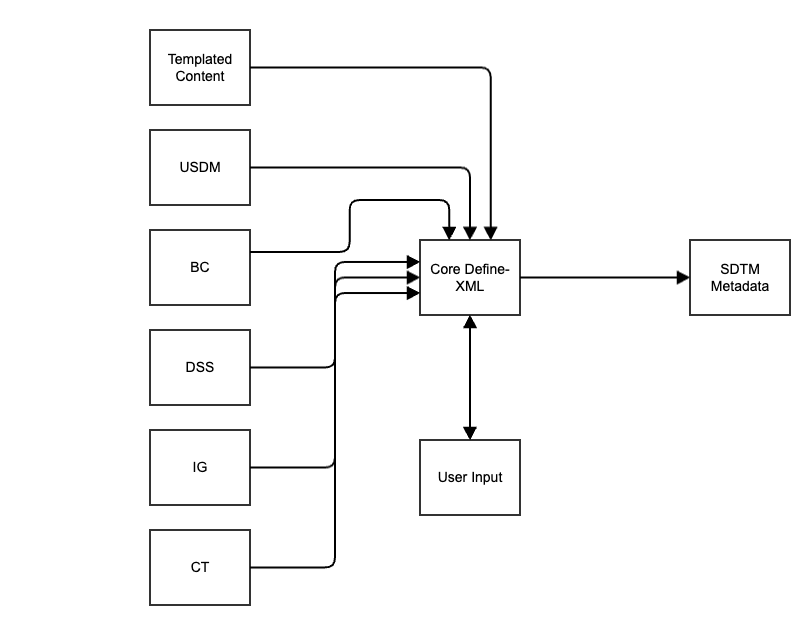

**Clone the Github respoitory containing the USDM utilities**

The cdisc-usdm-utils project includes utilities to generate SDTM domain outputs (CSV + Dataset-JSON v1.1), and XPT files from USDM.  Like all other repositories used in the notebooks, this project is public and distributed under the MIT license.  Feel free to clone and fork the repository as well as raise Issues, feature requests and Pull requests for tested changes.

In [30]:
# @title
# Clone the utilities

change_working_dir(WORKING_DIR)
repo = 'https://github.com/pendingintent/cdisc-usdm-utils'
branch = 'dataset-xpt'
!git clone -b {branch} {repo}
project = urlparse(repo)[2]
utils_dir = project[project.rindex('/')+1:len(project)]
WORKING_DIRS.append(os.path.join(WORKING_DIR, utils_dir))
change_working_dir(utils_dir)

INFO: Changing to the /content working directory...
Cloning into 'cdisc-usdm-utils'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (376/376), done.
remote: Compressing objects: 100% (234/234), done.
remote: Total 376 (delta 172), reused 294 (delta 105), pack-reused 0 (from 0)
Receiving objects: 100% (376/376), 4.83 MiB | 10.88 MiB/s, done.
Resolving deltas: 100% (172/172), done.
INFO: Changing to the cdisc-usdm-utils working directory...


### Create the Trial Design Datasets

**Create TA, TE, TV, TI and TS Trial Design Domains**

The cdisc-usdm-utils and the uploaded USDM JSON file are used to create the Trial Design Domains using specifications included in the utilities.  This is another example of open-source utilties created in collaboration with the CDISC 360i team.

In [31]:
# @title
# execute the utility to create the trial design domains TA, TV, TE, TI, TS

change_working_dir(utils_dir)
# Install the package in editable mode
!pip install -e .
print(usdm_file_path)
print("INFO: Creating Trial Domain Datasets from {}".format(usdm_file_path))
!python -m cdisc_usdm_utils.cli sdtm all --usdm-file {usdm_file_path} --out-dir {DATASET_DIR}

INFO: Changing to the cdisc-usdm-utils working directory...
ERROR: cdisc-usdm-utils does not exist...
Obtaining file:///content/cdisc-usdm-utils
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for cdisc-usdm-utils (pyproject.toml) ... done
  Created wheel for cdisc-usdm-utils: filename=cdisc_usdm_utils-0.1.0-0.editable-py3-none-any.whl size=2540 sha256=180ed2d13a1506f75e82eabbfa207b045347ce07d6cb02f8183788d18c331943
  Stored in directory: /tmp/pip-ephem-wheel-cache-w0d6eqmq/wheels/71/42/aa/7f62b1b255ef2b5ffdf2b4237de83f7b10fb9f3dc37b5460b7
Successfully built cdisc-usdm-utils
  Attempting uninstall: cdisc-usdm-utils
    Found existing installation: cdisc-usdm-utils 0.1.0
    Uninstalling cdisc-usdm-utils-0.1.0:
      Successfully uninstalled cdisc-usdm-utils-0.1.0
/content/drive/MyDrive/TMF/H2Q-MC-LZZT/protoco

**Generate the Trial Design Domain XPT files for CORE validation**

The notebook installation of our CDISC Conformance Rules Engine executes against XPT format dataset files.

The cdisc-usdm-utils is used to produce submission-ready SAS XPT files.

In [32]:
# @title
# Ensure the xpt directory exists and generate the XPT files

!pip install pyreadstat
xpt_dir = os.path.join(DATASET_DIR, 'xpt')
create_dir(xpt_dir)
!python -m cdisc_usdm_utils.cli xpt --csv-dir {DATASET_DIR} --out-dir {xpt_dir}

INFO: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/xpt exists...
XPT export complete.


**View the contents of the TA domain**

(Optional) View the contents of the TA domain to ensure it meets expectations.

In [33]:
# @title
# Display TA domain as DataFrame

df = pd.read_csv(os.path.join(DATASET_DIR, "TA.csv"))
display(df)

STUDYID DOMAIN                 ARMCD               ARM  TAETORD ETCD  \
0   H2Q-MC-LZZT     TA               Placebo           Placebo        1  EL1   
1   H2Q-MC-LZZT     TA               Placebo           Placebo        1  EL2   
2   H2Q-MC-LZZT     TA               Placebo           Placebo        1  EL2   
3   H2Q-MC-LZZT     TA               Placebo           Placebo        1  EL2   
4   H2Q-MC-LZZT     TA               Placebo           Placebo        1  EL7   
5   H2Q-MC-LZZT     TA   Xanomeline Low Dose  Active Substance        1  EL1   
6   H2Q-MC-LZZT     TA   Xanomeline Low Dose  Active Substance        1  EL3   
7   H2Q-MC-LZZT     TA   Xanomeline Low Dose  Active Substance        1  EL3   
8   H2Q-MC-LZZT     TA   Xanomeline Low Dose  Active Substance        1  EL3   
9   H2Q-MC-LZZT     TA   Xanomeline Low Dose  Active Substance        1  EL7   
10  H2Q-MC-LZZT     TA  Xanomeline High Dose  Active Substance        1  EL1   
11  H2Q-MC-LZZT     TA  Xanomeline High Dose  Active Substance        1  EL4   
12  H2Q-MC-LZZT     TA  Xanomeline High Dose  Active Substance        1  EL5   
13  H2Q-MC-LZZT     TA  Xanomeline High Dose  Active Substance        1  EL6   
14  H2Q-MC-LZZT     TA  Xanomeline High Dose  Active Substance        1  EL7   

                                              ELEMENT  TABRANCH  TATRANS  \
0                                   Screening Element       NaN      NaN   
1                      Placebo TTS (adhesive patches)       NaN      NaN   
2                      Placebo TTS (adhesive patches)       NaN      NaN   
3                      Placebo TTS (adhesive patches)       NaN      NaN   
4                                   Follow Up Element       NaN      NaN   
5                                   Screening Element       NaN      NaN   
6     Xanomeline TTS (adhesive patches) 50 cm2, 54 mg       NaN      NaN   
7     Xanomeline TTS (adhesive patches) 50 cm2, 54 mg       NaN      NaN   
8     Xanomeline TTS (adhesive patches) 50 cm2, 54 mg       NaN      NaN   
9                                   Follow Up Element       NaN      NaN   
10                                  Screening Element       NaN      NaN   
11    Xanomeline TTS (adhesive patches) 50 cm2, 54 mg       NaN      NaN   
12  Xanomeline TTS (adhesive patches) 50 cm2, 54 m...       NaN      NaN   
13    Xanomeline TTS (adhesive patches) 50 cm2, 54 mg       NaN      NaN   
14                                  Follow Up Element       NaN      NaN   

          EPOCH  
0     Screening  
1   Treatment 1  
2   Treatment 2  
3   Treatment 3  
4     Follow-Up  
5     Screening  
6   Treatment 1  
7   Treatment 2  
8   Treatment 3  
9     Follow-Up  
10    Screening  
11  Treatment 1  
12  Treatment 2  
13  Treatment 3  
14    Follow-Up

**View the contents of the TE domain**

(Optional) View the contents of the TE domain to ensure it meets expectations.

In [34]:
# @title
# Display TE domain as DataFrame

df = pd.read_csv(os.path.join(DATASET_DIR, "TE.csv"))
display(df)

STUDYID DOMAIN ETCD                                            ELEMENT  \
0  H2Q-MC-LZZT     TE  EL1                                  Screening Element   
1  H2Q-MC-LZZT     TE  EL2                     Placebo TTS (adhesive patches)   
2  H2Q-MC-LZZT     TE  EL7                                  Follow Up Element   
3  H2Q-MC-LZZT     TE  EL3    Xanomeline TTS (adhesive patches) 50 cm2, 54 mg   
4  H2Q-MC-LZZT     TE  EL4    Xanomeline TTS (adhesive patches) 50 cm2, 54 mg   
5  H2Q-MC-LZZT     TE  EL5  Xanomeline TTS (adhesive patches) 50 cm2, 54 m...   
6  H2Q-MC-LZZT     TE  EL6    Xanomeline TTS (adhesive patches) 50 cm2, 54 mg   

                                              TESTRL  \
0                                   Informed consent   
1                       Administration of first dose   
2  End of last scheduled visit on study (includin...   
3                       Administration of first dose   
4                                         Randomized   
5  Administration of first dose (from patches sup...   
6  Administration of first dose (from patches sup...   

                                              TEENRL  TEDUR  
0  Completion of all screening activities and no ...    NaN  
1                                                NaN    NaN  
2  Completion of all specified followup activitie...    NaN  
3                                                NaN    NaN  
4                                                NaN    NaN  
5                                                NaN    NaN  
6                                                NaN    NaN

**View the contents of the TV domain**

(Optional) View the contents of the TV domain to ensure it meets expectations.

In [35]:
# @title
# Display TV domain as DataFrame

df = pd.read_csv(os.path.join(DATASET_DIR, "TV.csv"))
display(df)

STUDYID DOMAIN  VISITNUM VISIT  VISITDY                 ARMCD  \
0   H2Q-MC-LZZT     TV         1    E1      0.0               Placebo   
1   H2Q-MC-LZZT     TV         2    E2      NaN               Placebo   
2   H2Q-MC-LZZT     TV         3    E3      NaN               Placebo   
3   H2Q-MC-LZZT     TV         4    E4     14.0               Placebo   
4   H2Q-MC-LZZT     TV         5    E5     28.0               Placebo   
5   H2Q-MC-LZZT     TV         6    E7     42.0               Placebo   
6   H2Q-MC-LZZT     TV         7    E8     56.0               Placebo   
7   H2Q-MC-LZZT     TV         8    E9     84.0               Placebo   
8   H2Q-MC-LZZT     TV         9   E10    112.0               Placebo   
9   H2Q-MC-LZZT     TV        10   E11    140.0               Placebo   
10  H2Q-MC-LZZT     TV        11   E12    168.0               Placebo   
11  H2Q-MC-LZZT     TV        12   E13    182.0               Placebo   
12  H2Q-MC-LZZT     TV         1    E1      0.0   Xanomeline Low Dose   
13  H2Q-MC-LZZT     TV         2    E2      NaN   Xanomeline Low Dose   
14  H2Q-MC-LZZT     TV         3    E3      NaN   Xanomeline Low Dose   
15  H2Q-MC-LZZT     TV         4    E4     14.0   Xanomeline Low Dose   
16  H2Q-MC-LZZT     TV         5    E5     28.0   Xanomeline Low Dose   
17  H2Q-MC-LZZT     TV         6    E7     42.0   Xanomeline Low Dose   
18  H2Q-MC-LZZT     TV         7    E8     56.0   Xanomeline Low Dose   
19  H2Q-MC-LZZT     TV         8    E9     84.0   Xanomeline Low Dose   
20  H2Q-MC-LZZT     TV         9   E10    112.0   Xanomeline Low Dose   
21  H2Q-MC-LZZT     TV        10   E11    140.0   Xanomeline Low Dose   
22  H2Q-MC-LZZT     TV        11   E12    168.0   Xanomeline Low Dose   
23  H2Q-MC-LZZT     TV        12   E13    182.0   Xanomeline Low Dose   
24  H2Q-MC-LZZT     TV         1    E1      0.0  Xanomeline High Dose   
25  H2Q-MC-LZZT     TV         2    E2      NaN  Xanomeline High Dose   
26  H2Q-MC-LZZT     TV         3    E3      NaN  Xanomeline High Dose   
27  H2Q-MC-LZZT     TV         4    E4     14.0  Xanomeline High Dose   
28  H2Q-MC-LZZT     TV         5    E5     28.0  Xanomeline High Dose   
29  H2Q-MC-LZZT     TV         6    E7     42.0  Xanomeline High Dose   
30  H2Q-MC-LZZT     TV         7    E8     56.0  Xanomeline High Dose   
31  H2Q-MC-LZZT     TV         8    E9     84.0  Xanomeline High Dose   
32  H2Q-MC-LZZT     TV         9   E10    112.0  Xanomeline High Dose   
33  H2Q-MC-LZZT     TV        10   E11    140.0  Xanomeline High Dose   
34  H2Q-MC-LZZT     TV        11   E12    168.0  Xanomeline High Dose   
35  H2Q-MC-LZZT     TV        12   E13    182.0  Xanomeline High Dose   

                 ARM                                             TVSTRL  \
0            Placebo                                 Subject identifier   
1            Placebo                                                NaN   
2            Placebo  subject has connection of ambulatory ECG machi...   
3            Placebo                                                NaN   
4            Placebo                                                NaN   
5            Placebo                                                NaN   
6            Placebo                                                NaN   
7            Placebo                                                NaN   
8            Placebo                                                NaN   
9            Placebo                                                NaN   
10           Placebo                                                NaN   
11           Placebo                                                NaN   
12  Active Substance                                 Subject identifier   
13  Active Substance                                                NaN   
14  Active Substance  subject has connection of ambulatory ECG machi...   
15  Active Substance                                                NaN   
16  Active Substance           

**Validate conformance using the CORE engine**

As seen in the Study Design notebook demonstration, the CDISC CORE Engine can be used to run Conformance Rules from the CDISC Library to validate the SDTM Trial Design Domains.  A validation report is created for any validation executed by the CORE Engine.

In [36]:
# @title
# execute SDTM validation

change_working_dir(os.path.join(WORKING_DIR, 'core'))
destination_path = os.path.join(REPORT_DIR, 'sdtm_validation_results')
!./core validate -s SDTMIG -v 3-4 -o {destination_path} -d {xpt_dir}

INFO: Changing to the /content/core working directory...
pkg_resources/__init__.py:2211: UserWarning: /content/core/._cryptography-3.4.8.egg-info could not be properly decoded in UTF-8
pkg_resources/__init__.py:2211: UserWarning: /content/core/._wheel-0.37.1.egg-info could not be properly decoded in UTF-8
  [████████████████████████████████████]  100%
Output: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/reports/sdtm_validation_results


**View the Rules Report list of USDM core tests executed**

View the Summary Rules Report from the CORE Report XLSX file.

Do not show the SKIPPED rules.

In [37]:
# @title
# Create a pandas dataframe to view the Rules Report worksheet in the report
# produced by the CORE Engine

results_file = destination_path + '.xlsx'
df = pd.read_excel(results_file, sheet_name='Rules Report')
df = df[(df['Status']=='SUCCESS')]
display(df)

CORE-ID  Version                      CDISC RuleID  \
17   CORE-000019        1   CG0311, SEND3, TIG0211, TIG0486   
177  CORE-000182        1   CG0310, SEND2, TIG0128, TIG0485   
327  CORE-000581        1                   CG0368, TIG0532   
329  CORE-000594        1  CG0359, SEND29, TIG0205, TIG0524   
331  CORE-000598        1   CG0413, SEND1, TIG0037, TIG0568   
373  CORE-000739        1                            CG0407   

             FDA RuleID                                            Message  \
17                  NaN  Variable label length should be less than or e...   
177                 NaN            Variable name length is greater than 8.   
327  TRC1736a, TRC1736c                             DM dataset is missing.   
329                 NaN               Variable label is not in title case.   
331                 NaN      Dataset name does not begin with DOMAIN value   
373                 NaN  EX is not present in study when study includes...   

      Status  
17   SUCCESS  
177  SUCCESS  
327  SUCCESS  
329  SUCCESS  
331  SUCCESS  
373  SUCCESS

**View the Issue Sumary produced by the CORE Engine**

View the Issue Summary from the Core Report XLSX file.

In [38]:
# @title
# Create a pandas dataframe to view the Issue Summary worksheet in the report
# produced by the CORE Engine

df = pd.read_excel(results_file, sheet_name='Issue Summary')
display(df)

Dataset      CORE-ID                                            Message  \
0   TA.xpt  CORE-000581                             DM dataset is missing.   
1   TA.xpt  CORE-000739  EX is not present in study when study includes...   
2   TE.xpt  CORE-000581                             DM dataset is missing.   
3   TE.xpt  CORE-000739  EX is not present in study when study includes...   
4   TI.xpt  CORE-000581                             DM dataset is missing.   
5   TI.xpt  CORE-000739  EX is not present in study when study includes...   
6   TS.xpt  CORE-000581                             DM dataset is missing.   
7   TS.xpt  CORE-000739  EX is not present in study when study includes...   
8   TV.xpt  CORE-000581                             DM dataset is missing.   
9   TV.xpt  CORE-000739  EX is not present in study when study includes...   
10  VS.xpt  CORE-000581                             DM dataset is missing.   
11  VS.xpt  CORE-000739  EX is not present in study when study includes...   

    Issues  Explanation  
0        1          NaN  
1        1          NaN  
2        1          NaN  
3        1          NaN  
4        1          NaN  
5        1          NaN  
6        1          NaN  
7        1          NaN  
8        1          NaN  
9        1          NaN  
10       1          NaN  
11       1          NaN

The SDTM Trial Design Domain files for the domains TA, TE, TV, TI and TS were created using the tools in the cdisc-usdm-utils library in CSV, JSON and XPT formats.

The CORE Engine was used to execute the SDTMIG v3-4 Conformance Rules from the CDISC Library against the XPT version of the SDTM Trial Desigm Domain files.

Finally, we viewed the Rules Report and Issue Summary produced by the CORE execution.

In [40]:
# @title
# Copy files to Object Storage or Study Operational Data Store

dest_json = os.path.join(DATASET_DIR, 'json')
dest_csv = os.path.join(DATASET_DIR, 'csv')
destlist = [dest_json, dest_csv]

for dest in destlist:
  try:
    os.makedirs(dest)
  except FileExistsError:
    print("INFO: Directory {} already exists...".format(dest))

for file in os.listdir(DATASET_DIR):

  if file.endswith(".csv"):
    print("INFO: Moving {} to {}...".format(file, dest_csv))
    shutil.move(os.path.join(DATASET_DIR, file), os.path.join(dest_csv, file))
  elif file.endswith(".json"):
    print("INFO: Moving {} to {}...".format(file, dest_json))
    shutil.move(os.path.join(DATASET_DIR, file), os.path.join(dest_json, file.replace(".dataset", "")))

INFO: Directory /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/json already exists...
INFO: Directory /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/csv already exists...
INFO: Moving TA.csv to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/csv...
INFO: Moving TA.dataset.json to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/json...
INFO: Moving TE.csv to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/csv...
INFO: Moving TE.dataset.json to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/json...
INFO: Moving TV.csv to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/csv...
INFO: Moving TV.dataset.json to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/json...
INFO: Moving TI.csv to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/csv...
INFO: Moving TI.dataset.json to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/json...
INFO: Moving TS.csv to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/csv...
INFO: Moving TS.dataset.json to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/json.

Once again, all assets are copied to the Operational Data Store.

### Create Define-XML

The Define-Template utility is an open-source solution designed to create the template file used in the creation of the Define-XML file from the study definition in the USDM JSON file.

In [41]:
# @title
# Clone the GitHub repository that contains the Define-Template utility

change_working_dir(WORKING_DIR)
repo = 'https://github.com/pendingintent/360i'
branch = 'parse-args'
!git clone -b {branch} {repo}
project = urlparse(repo)[2]
template_util_dir = project[project.rindex('/')+1:len(project)]
WORKING_DIRS.append(os.path.join(WORKING_DIR, template_util_dir))
change_working_dir(template_util_dir)

INFO: Changing to the /content working directory...
Cloning into '360i'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 79 (delta 38), reused 66 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (79/79), 151.32 KiB | 1.78 MiB/s, done.
Resolving deltas: 100% (38/38), done.
INFO: Changing to the 360i working directory...


**Execute the code to create the Define-Template file**

Creation of the template takes approximately 8 minutes.  For the purposes of this demonstration, the Define Template will be copied from the Operational Data Store.

In order to execute the utility to create the Define Template, execute the following command:
```
!python Define-Template.py --usdm_file {usdm_file_path} --output_template {output_template_file} --cdisc_api_key {cdisc_api_key}
```

**View the Define-Template.json file**

In [42]:
# @title
# Display the generated Define Template

define_template_file = os.path.join(CONTENT_DIR, 'Define-Template.json')
display(JSON(define_template_file))


<IPython.core.display.JSON object>

**Clone the repository for creating the Define-XML file**

The Define Template is used by this open-source solution to generate the Define XML.

In [43]:
# @title
# Clone the utility for generating the Define-XML

change_working_dir(WORKING_DIR)
!pip install odmlib
repo = 'https://github.com/swhume/template2define'
!git clone {repo}
project = urlparse(repo)[2]
define_util_dir = project[project.rindex('/')+1:len(project)]
WORKING_DIRS.append(os.path.join(WORKING_DIR, define_util_dir))
change_working_dir(define_util_dir)

INFO: Changing to the /content working directory...
  Using cached odmlib-0.1.4-py3-none-any.whl.metadata (4.2 kB)
Using cached odmlib-0.1.4-py3-none-any.whl (311 kB)
Cloning into 'template2define'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 29 (delta 4), reused 29 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 56.66 KiB | 725.00 KiB/s, done.
Resolving deltas: 100% (4/4), done.
INFO: Changing to the template2define working directory...


**Execute the utility to generate the Define-XML**

In [44]:
# @title
# Generate the Define-XML

template = os.path.join(CONTENT_DIR, 'Define-Template.json')
define_xml = os.path.join(DATASET_DIR, 'define.xml')
!python template2define2-1.py -t {template} -d {define_xml}

Study
Standards
Datasets
CodeLists


**Display the define.xml file**

In [45]:
# @title
# Format using xmllint for easier viewing

!xmllint --format {define_xml} -o {define_xml}
!head -100 {define_xml}

<?xml version="1.0" encoding="utf-8"?>
<ODM xmlns="http://www.cdisc.org/ns/odm/v1.3" xmlns:xs="http://www.w3.org/2001/XMLSchema-instance" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:def="http://www.cdisc.org/ns/def/v2.1" FileOID="ODM.DEFINE21.360i.001" AsOfDateTime="2025-10-01T17:54:21.486038+00:00" CreationDateTime="2025-10-01T17:54:21.486081+00:00" ODMVersion="1.3.2" FileType="Snapshot" Originator="360i Define-XML Team" SourceSystem="odmlib" SourceSystemVersion="0.2" def:Context="Other">
  <Study OID="ODM.LZZT---NEW">
    <GlobalVariables>
      <StudyName>LZZT - NEW</StudyName>
      <StudyDescription>Safety and Efficacy of the Xanomeline Transdermal Therapeutic System (TTS) in Patients with Mild to Moderate Alzheimer's Disease</StudyDescription>
      <ProtocolName>LZZT - NEW</ProtocolName>
    </GlobalVariables>
    <MetaDataVersion OID="MDV.LZZT---NEW" Name="MDV LZZT - NEW" Description="Data Definitions for LZZT - NEW" def:DefineVersion="2.1.0">
      <def:Standards>
       

### Create the Required SDTM Shell Dataset JSON files from the define.xml

Variables required by the SDTM datasets can be determined using the newly create define.xml.  

Therefore, dataset definitions describing these variables can be created at this stage.

In [47]:
# @title
# Create the empty shell dataset JSON files

change_working_dir(os.path.join(WORKING_DIR, template_util_dir))
#print(SHELL_DIR)
!python dataset-json.py --define_file {define_xml} --output_dir {SHELL_DIR}

INFO: Changing to the /content/360i working directory...


View the Domains for which empty shell datasets have been created.

In [48]:
%ls {SHELL_DIR}

AE.json  DM.json  EC.json  LB.json  MH.json  SC.json  VS.json
CM.json  DS.json  EG.json  MB.json  PR.json  SU.json


**Display the Vital Signs JSON shell dataset for demonstration**

In [49]:
# @title
# Display the VS JSON empty shell dataset

display(JSON(os.path.join(SHELL_DIR, 'VS.json')))

<IPython.core.display.JSON object>

Creation of the Trial Design Datasets, Define-XML and SDTM Domain dataset definition study artifacts can be automated using open-source solutions currently available and created in collaboration with teams at CDISC.



---



## Data Collection and the Operational Data Store (ODS)

As mentioned at the beginning of this demostration, the Operational Data Store serves as a repository for all study data and improves data governance and traceability for all study teams.

The Google Drive serves as the Object Store for the Operational Data Store.  All assets created to this point now exist in the object store.

Once the study has gone live and subject data is being entered at the sites, this raw, collected data is imported into the ODS and stored in a database.  The data loaded into the database is made available to study teams for further downsteam processing, such as the creation of the SDTM data sets.

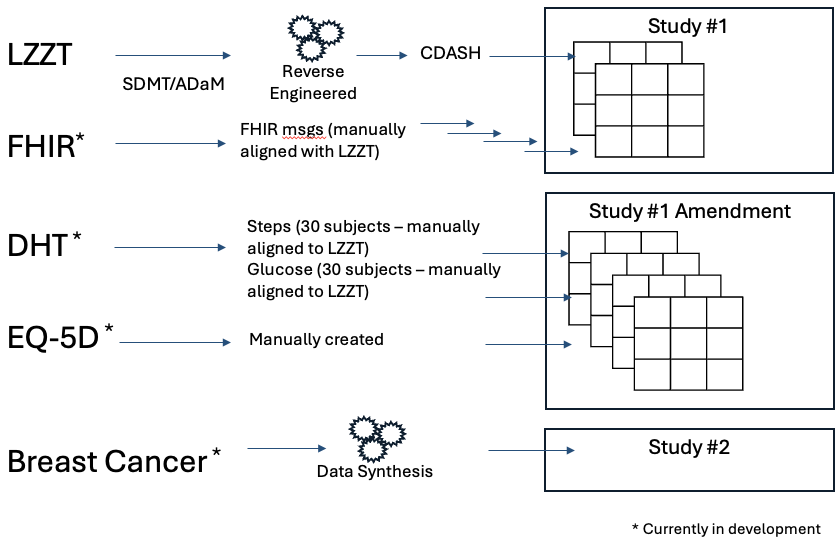

**Create an Operational Data Store database for use in the demonstration**

Typically a database will exist for the storage of all study data.  For this demonstration, an sqlite database will be created and study data stored in the database.

In [56]:
# @title
# Create an ODS

import sqlite3
change_working_dir(DATABASE_DIR)
ods_db = 'ods.db'

if os.path.exists(os.path.join(DATABASE_DIR, ods_db)):
  os.remove(os.path.join(DATABASE_DIR, ods_db))

try:
  with sqlite3.connect(os.path.join(DATABASE_DIR, ods_db), timeout=10) as conn:
    print("INFO: Creating database {}".format(ods_db))
    conn
except sqlite3.OperationalError as e:
  print("ERROR: Failed to create database: {}".format(e))
finally:
  print("INFO: Closing database connection...")
  conn.close()

INFO: Changing to the /content/drive/MyDrive/TMF/H2Q-MC-LZZT/clinical_database working directory...
INFO: Creating database ods.db
INFO: Closing database connection...


**Download raw subject data**

Often raw data sets will be stored in object storage and made available to teams for downstream processing.

To emulate this environment, download raw data files from Github.

Raw data sets are available: https://github.com/alidootson/UpdatedCDISCPilotData/tree/main/UpdatedCDISCPilotData/CDASH

The directories include XPT, JSON and CSV format files.

Data is transferred in the open Parquet file format, which provides efficient data compression and encoding schemes with enhanced performance to handle complex data in bulk.


In [51]:
# @title
# Download CSV files from repo and write out to parquet files to the ODS
# clinical_data directory

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd

change_working_dir(CLINICAL_DIR)
domains = ['AE','CM','DM','DS','EX','IE','LB','MH','QS','SC','VS','X1']
repo = 'https://raw.githubusercontent.com/alidootson/UpdatedCDISCPilotData/refs/heads/main/UpdatedCDISCPilotData/CDASH/csv%20versions'

for domain in domains:
  if domain + '.csv' in os.listdir():
    continue
  else:
    file_path = repo + '/' + domain + '.csv'
    df = pd.read_csv(file_path)
    table = pa.Table.from_pandas(df)
    pq.write_table(table, domain + '.parquet')

INFO: Changing to the /content/drive/MyDrive/TMF/H2Q-MC-LZZT/clinical_data working directory...


**Read AE parquet domain file**

Parquet files are a non-human-readable format. Convert into a Pandas dataframe for viewing.

In [52]:
# @title
# Verify the contents of AE

pd.read_parquet(os.path.join(CLINICAL_DIR, 'AE.parquet'), engine='pyarrow')

STUDYID  SITEID  SUBJID AEYN AESPID                       AETERM  \
0     CDISCPILOT01     701    1015    Y    E06                    DIARRHOEA   
1     CDISCPILOT01     701    1015    Y    E07    APPLICATION SITE ERYTHEMA   
2     CDISCPILOT01     701    1015    Y    E08    APPLICATION SITE PRURITUS   
3     CDISCPILOT01     701    1023    Y    E08                     ERYTHEMA   
4     CDISCPILOT01     701    1023    Y    E08                     ERYTHEMA   
...            ...     ...     ...  ...    ...                          ...   
1267  CDISCPILOT01     718    1427    Y    E13  APPLICATION SITE DERMATITIS   
1268  CDISCPILOT01     718    1427    Y    E14           DECREASED APPETITE   
1269  CDISCPILOT01     718    1427    Y    E14           DECREASED APPETITE   
1270  CDISCPILOT01     718    1427    Y    E15                       NAUSEA   
1271  CDISCPILOT01     718    1427    Y    E15                       NAUSEA   

                         AELLT  AELLTCD                      AEDECOD  AEPTCD  \
0                     DIARRHEA      NaN                    DIARRHOEA     NaN   
1     APPLICATION SITE REDNESS      NaN    APPLICATION SITE ERYTHEMA     NaN   
2     APPLICATION SITE ITCHING      NaN    APPLICATION SITE PRURITUS     NaN   
3                     ERYTHEMA      NaN                     ERYTHEMA     NaN   
4                     ERYTHEMA      NaN                     ERYTHEMA     NaN   
...                        ...      ...                          ...     ...   
1267     APPLICATION SITE RASH      NaN  APPLICATION SITE DERMATITIS     NaN   
1268        DECREASED APPETITE      NaN           DECREASED APPETITE     NaN   
1269        DECREASED APPETITE      NaN           DECREASED APPETITE     NaN   
1270                    NAUSEA      NaN                       NAUSEA     NaN   
1271                    NAUSEA      NaN                       NAUSEA     NaN   

      ... AESDISAB  AESDTH DTHDAT  AESHOSP AESLIFE  AESOD        AEDAT  \
0     ...        N       N   None        N       N      N  16-JAN-2014   
1     ...        N       N   None        N       N      N  16-JAN-2014   
2     ...        N       N   None        N       N      N  16-JAN-2014   
3     ...        N       N   None        N       N      N  27-AUG-2012   
4     ...        N       N   None        N       N      N  02-SEP-2012   
...   ...      ...     ...    ...      ...     ...    ...          ...   
1267  ...        N       N   None        N       N      N  18-FEB-2013   
1268  ...        N       N   None        N       N      N  18-FEB-2013   
1269  ...        N       N   None        N       N      N  03-JUN-2013   
1270  ...        N       N   None        N       N      N  18-FEB-2013   
1271  ...        N       N   None        N       N      N  03-JUN-2013   

          AESTDAT      AEENDAT  AEONGO  
0     09-JAN-2014  11-JAN-2014       N  
1     03-JAN-2014         None       Y  
2     03-JAN-2014         None       Y  
3     07-AUG-2012  30-AUG-2012       N  
4     07-AUG-2012  30-AUG-2012       N  
...           ...          ...     ...  
1267  29-JAN-2013         None       Y  
1268  04-FEB-2013  25-FEB-2013       N  
1269  04-FEB-2013  25-FEB-2013       N  
1270  04-FEB-2013  25-FEB-2013       N  
1271  04-FEB-2013  25-FEB-2013       N  

[1272 rows x 33 columns]

**Read VS parquet domain file**

In [53]:
# @title
# Verify the contents of VS

pd.read_parquet(os.path.join(CLINICAL_DIR, 'VS.parquet'), engine='pyarrow')

STUDYID  SITEID  SUBJID DIABP_VSPOS SYSBP_VSPOS PULSE_VSPOS  \
0     CDISCPILOT01     701    1015      SUPINE      SUPINE      SUPINE   
1     CDISCPILOT01     701    1015    STANDING    STANDING    STANDING   
2     CDISCPILOT01     701    1015    STANDING    STANDING    STANDING   
3     CDISCPILOT01     701    1015      SUPINE      SUPINE      SUPINE   
4     CDISCPILOT01     701    1015    STANDING    STANDING    STANDING   
...            ...     ...     ...         ...         ...         ...   
8206  CDISCPILOT01     718    1427    STANDING    STANDING    STANDING   
8207  CDISCPILOT01     718    1427    STANDING    STANDING    STANDING   
8208  CDISCPILOT01     718    1427      SUPINE      SUPINE      SUPINE   
8209  CDISCPILOT01     718    1427    STANDING    STANDING    STANDING   
8210  CDISCPILOT01     718    1427    STANDING    STANDING    STANDING   

      DIABP_VSORRES  HEIGHT_VSORRES  PULSE_VSORRES  SYSBP_VSORRES  ...  \
0              64.0            58.0           57.0          131.0  ...   
1              83.0             NaN           62.0          129.0  ...   
2              57.0             NaN           65.0          147.0  ...   
3              68.0             NaN           56.0          138.0  ...   
4              59.0             NaN           60.0          137.0  ...   
...             ...             ...            ...            ...  ...   
8206           98.0             NaN           74.0          164.0  ...   
8207           80.0             NaN           70.0          147.0  ...   
8208           64.0             NaN           56.0          131.0  ...   
8209           67.0             NaN           70.0          129.0  ...   
8210           67.0             NaN           65.0          136.0  ...   

      PULSE_VSDAT  SYSBP_VSDAT   TEMP_VSDAT WEIGHT_VSDAT  \
0     26-DEC-2013  26-DEC-2013  26-DEC-2013  26-DEC-2013   
1     26-DEC-2013  26-DEC-2013         None         None   
2     26-DEC-2013  26-DEC-2013         None         None   
3     31-DEC-2013  31-DEC-2013  31-DEC-2013         None   
4     31-DEC-2013  31-DEC-2013         None         None   
...           ...          ...          ...          ...   
8206  18-FEB-2013  18-FEB-2013         None         None   
8207  18-FEB-2013  18-FEB-2013         None         None   
8208  03-JUN-2013  03-JUN-2013  03-JUN-2013         None   
8209  03-JUN-2013  03-JUN-2013         None         None   
8210  03-JUN-2013  03-JUN-2013         None         None   

                         DIABP_VSTPT                     SYSBP_VSTPT  \
0     AFTER LYING DOWN FOR 5 MINUTES  AFTER LYING DOWN FOR 5 MINUTES   
1        AFTER STANDING FOR 1 MINUTE     AFTER STANDING FOR 1 MINUTE   
2       AFTER STANDING FOR 3 MINUTES    AFTER STANDING FOR 3 MINUTES   
3     AFTER LYING DOWN FOR 5 MINUTES  AFTER LYING DOWN FOR 5 MINUTES   
4        AFTER STANDING FOR 1 MINUTE     AFTER STANDING FOR 1 MINUTE   
...                              ...                             ...   
8206     AFTER STANDING FOR 1 MINUTE     AFTER STANDING FOR 1 MINUTE   
8207    AFTER STANDING FOR 3 MINUTES    AFTER STANDING FOR 3 MINUTES   
8208  AFTER LYING DOWN FOR 5 MINUTES  AFTER LYING DOWN FOR 5 MINUTES   
8209     AFTER STANDING FOR 1 MINUTE     AFTER STANDING FOR 1 MINUTE   
8210    AFTER STANDING FOR 3 MINUTES    AFTER STANDING FOR 3 MINUTES   

                         PULSE_VSTPT DIABP_VSTPTNUM SYSBP_VSTPTNUM  \
0     AFTER LYING DOWN FOR 5 MINUTES          815.0          815.0   
1        AFTER STANDING FOR 1 MINUTE          816.0          816.0   
2       AFTER STANDING FOR 3 MINUTES          817.0          817.0   
3     AFTER LYING DOWN FOR 5 MINUTES          815.0          815.0   
4        AFTER STANDING FOR 1 MINUTE          816.0          816.0   
...                              ...            ...            ...   
8206     AFTER STANDING FOR 1 MINUTE          816.0          816.0   
8207    AFTER STANDING FOR 3 MINUTES          817.0          817.0   
8208  AFTER LYING

Parquet files can then be used to create dataframes for cleaning and transformation.

**Insert the raw staudy data in the Operational Data Store database**

In [57]:
# @title
# Create tables in the ODS for each of the stored parquet files
# containing subject data

data_files = []
for file in os.listdir(CLINICAL_DIR):
  if file.endswith(".parquet"):
    data_files.append(file)

try:
  with sqlite3.connect(os.path.join(DATABASE_DIR, ods_db), timeout=10) as conn:
    for file in data_files:
      table = pq.read_table(os.path.join(CLINICAL_DIR, file))
      print("INFO: Creating table for {}".format(file))
      df = table.to_pandas()
      df.to_sql('raw_' + file.split('.')[0], conn, if_exists='replace', index = False)
      conn.commit()
except sqlite3.OperationalError as e:
  print("ERROR: Failed to open database: {}".format(e))
finally:
  print("INFO: Closing database connection...")
  conn.close()

INFO: Creating table for AE.parquet
INFO: Creating table for CM.parquet
INFO: Creating table for DM.parquet
INFO: Creating table for DS.parquet
INFO: Creating table for EX.parquet
INFO: Creating table for IE.parquet
INFO: Creating table for LB.parquet
INFO: Creating table for MH.parquet
INFO: Creating table for QS.parquet
INFO: Creating table for SC.parquet
INFO: Creating table for VS.parquet
INFO: Creating table for X1.parquet
INFO: Closing database connection...


**Confirm a table is created for each of the data sets**

The tables include the prefix '_raw' to differentiate them from processed data sets, i.e., SDTM, ADaM, etc.

In [75]:
# @title
# Confirm sqlite tables are created for the parquet files

try:
  with sqlite3.connect(os.path.join(DATABASE_DIR, ods_db)) as conn:
    cur = conn.cursor()
    cur.execute("SELECT name FROM sqlite_schema WHERE type=='table' AND name NOT LIKE 'sqlite_%';")
    print(cur.fetchall())
except sqlite3.OperationalError as e:
  print("ERROR: Failed to open database: {}".format(e))
finally:
  print("INFO: Closing database connection...")
  conn.close()



[('raw_AE',), ('raw_CM',), ('raw_DM',), ('raw_DS',), ('raw_EX',), ('raw_IE',), ('raw_LB',), ('raw_MH',), ('raw_QS',), ('raw_SC',), ('raw_VS',), ('raw_X1',)]
INFO: Closing database connection...


**Verify record and column counts are equivalent for parquet files and ODS tables**

Use the python `assert` statement to test both column and row counts are equal for the Parquet files and the database tables created for each Parquet file.

In [59]:
# @title
# Assert all parquet files have same record count as correponding data table

try:
  with sqlite3.connect(os.path.join(DATABASE_DIR, ods_db)) as conn:
    for file in data_files:
      domain = 'raw_' + file.split('.')[0]
      #print("Testing: {}".format(domain))
      cur = conn.cursor()
      cur.execute("SELECT COUNT(*) FROM {}".format(domain))
      assert cur.fetchone()[0] == pq.ParquetFile(os.path.join(CLINICAL_DIR, file)).metadata.num_rows
      print("INFO: {} domain passed validation".format(domain))
except sqlite3.OperationalError as e:
  print("ERROR: Failed to open database: {}".format(e))
except AssertionError as e:
  print("ERROR: Record count mismatch")
finally:
  print("INFO: Closing database connection...")
  conn.close()


INFO: raw_AE domain passed validation
INFO: raw_CM domain passed validation
INFO: raw_DM domain passed validation
INFO: raw_DS domain passed validation
INFO: raw_EX domain passed validation
INFO: raw_IE domain passed validation
INFO: raw_LB domain passed validation
INFO: raw_MH domain passed validation
INFO: raw_QS domain passed validation
INFO: raw_SC domain passed validation
INFO: raw_VS domain passed validation
INFO: raw_X1 domain passed validation
INFO: Closing database connection...


Display records in the raw vital signs table to confirm data has been inserted

SQL SELECT to preview records in the raw_VS table.

In [60]:
# @title
# Read data from raw_VS table in ODS

try:
  with sqlite3.connect(os.path.join(DATABASE_DIR, ods_db)) as conn:
    cur = conn.cursor()
    cur.execute("SELECT * FROM raw_VS")
    rows = cur.fetchmany(10)
    for row in rows:
        print(row)
except sqlite3.OperationalError as e:
  print("ERROR: Failed to open database: {}".format(e))
finally:
  print("INFO: Closing database connection...")
  conn.close()



('CDISCPILOT01', 701, 1015, 'SUPINE', 'SUPINE', 'SUPINE', 64.0, 58.0, 57.0, 131.0, 96.9, 119.0, 'mmHg', 'IN', 'BEATS/MIN', 'mmHg', 'F', 'LB', None, None, None, None, None, None, 'ORAL CAVITY', 'SCREENING 1', '26-DEC-2013', '26-DEC-2013', '26-DEC-2013', '26-DEC-2013', '26-DEC-2013', '26-DEC-2013', '26-DEC-2013', 'AFTER LYING DOWN FOR 5 MINUTES', 'AFTER LYING DOWN FOR 5 MINUTES', 'AFTER LYING DOWN FOR 5 MINUTES', 815.0, 815.0, 815.0)
('CDISCPILOT01', 701, 1015, 'STANDING', 'STANDING', 'STANDING', 83.0, None, 62.0, 129.0, None, None, 'mmHg', None, 'BEATS/MIN', 'mmHg', None, None, None, None, None, None, None, None, None, 'SCREENING 1', '26-DEC-2013', '26-DEC-2013', None, '26-DEC-2013', '26-DEC-2013', None, None, 'AFTER STANDING FOR 1 MINUTE', 'AFTER STANDING FOR 1 MINUTE', 'AFTER STANDING FOR 1 MINUTE', 816.0, 816.0, 816.0)
('CDISCPILOT01', 701, 1015, 'STANDING', 'STANDING', 'STANDING', 57.0, None, 65.0, 147.0, None, None, 'mmHg', None, 'BEATS/MIN', 'mmHg', None, None, None, None, None, N

Clinical data and study assets come from various sources and disparate systems and need to be gathered in a central location.  An Operational Data Store represents a single location comprised of object storage and database(s) where all study objects can be stored to support downstream study requirements.

In this example, Google Object Storage is used to store and persist all study objects/assets used during study conduct.  A Relational Database is used to store tabular subject data collected during study conduct, which can then serve as the source for downstream transformations into SDTM submission datasets.



---



## SDTM Tabulation Dataset Generation

### The creation of SDTM Datasets in R with \{sdtm.oak}

One of the objectives of CDISC 360i is the automated generation of SDTM submission datasets leveraging Unified Study Definition Model (USDM), Biomedical Concepts (BC) and Data Set Specializations (DSS) terminologies combined with collected raw study data.  

The \{sdtm.oak} project is an Electronic Data Capture (EDC) and Data Standards agnostic solution that enables the pharmaceutical programming community to develop CDISC SDTM datasets using the R language.  This project provides a framework for modular programming leveraging reusable algorithms to achieve automation.


This approach improves data quality and consistency by applying standardized, validated algorithms derived directly from specifications, minimizing human coding errors leading to reduced timelines for analysis and reporting.



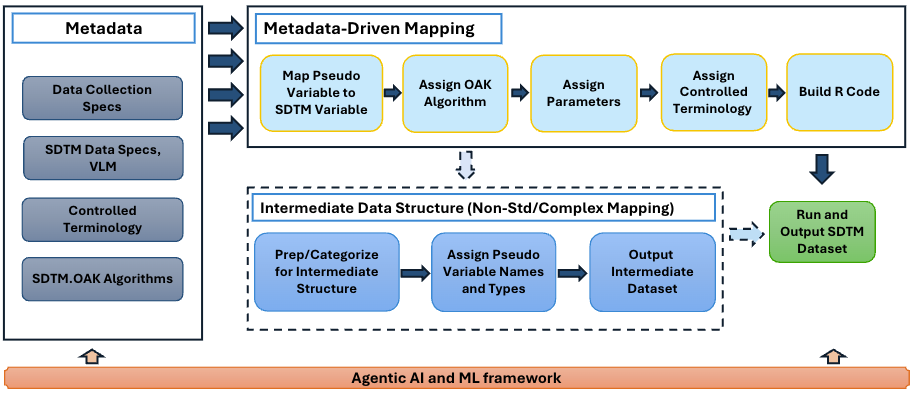

In order to use R code in this Python Notebook, load the required extensions.

In [61]:
# Setup the R environment within the Python Notebook
%load_ext rpy2.ipython

Confirm the artifacts for dynamically generating the domain creation script are present and can be accessed using **R**.

In [62]:
# @title
# Change to working directory and verify resources are accessible

%%R
working_dir <- "/content/drive/MyDrive/TMF/input_files"
setwd(working_dir)
getwd()
list.files()

[1] "cdisc_collection_dataset_specializations_draft.xlsx"
[2] "packages.txt"                                       
[3] "study_ct.csv"                                       
[4] "VS.csv"                                             
[5] "VS.R"                                               


The **%%R** magic statement is used to indicate the cell should be executed using the R interpreter.

**Confirm the environment is configured for R correctly**


Load any required **R** libraries.

In [63]:
# @title
# Install required libraries

%%R
# Path to your env file
env_file <- paste(working_dir, "packages.txt", sep = "/")   # change if needed

# Read all package names
pkgs <- scan(env_file, what = "", sep = "\n")

# Find which are missing
to_install <- setdiff(pkgs, rownames(installed.packages()))

# Install only missing ones
if (length(to_install) > 0) {
  install.packages(to_install)
} else {
  message("✅ All packages already installed")
}

Read 2 items
✅ All packages already installed


**Dynamically Generate the R script to create the VS Findings SDTM Domain**

In [64]:
# @title

# ==============================================================================
# CDISC SDTM Findings Domain Code Generator
# ==============================================================================
#
# File: emit_findings_oak_from_spec.R
# Purpose: Dynamically generate R code for mapping CDASH raw data to SDTM
#          Findings domains using sdtm.oak package
#
# Input:
#   - CDISC Collection Specializations Excel file
#   - Raw CDASH CSV data file
#   - Study controlled terminology CSV file
#
# Output:
#   - R script for SDTM Findings domain mapping
#   - Generated SDTM dataset CSV file
#
# Author: Auto-generated by CDISC 360I SDTM Oak Code Generator
# Version: 1.0
# Date: $(date)
#
# Dependencies: sdtm.oak, dplyr, readxl
# ==============================================================================
%%R
# Load required packages with error handling
tryCatch({
  if (!requireNamespace("readxl", quietly = TRUE)) {
    stop("Required package 'readxl' is not installed. Please run: install.packages('readxl')")
  }
  if (!requireNamespace("dplyr", quietly = TRUE)) {
    stop("Required package 'dplyr' is not installed. Please run: install.packages('dplyr')")
  }
}, error = function(e) {
  cat("ERROR: Package dependency check failed\n")
  cat("Details:", e$message, "\n")
  stop(e)
})

#' Generate SDTM Findings Domain Mapping Code
#'
#' @description
#' Dynamically generates R code for mapping CDASH raw data to SDTM Findings domains
#' using the sdtm.oak package. The function reads CDISC Collection Specializations,
#' raw data structure, and controlled terminology to produce optimized mapping code.
#'
#' @param spec_path Character. Path to CDISC Collection Specializations Excel file
#' @param raw_csv_path Character. Path to raw CDASH CSV data file
#' @param ct_csv_path Character. Path to study controlled terminology CSV file
#' @param domain Character. Target SDTM domain code (default: "VS")
#' @param out_r_path Character. Output path for generated R script (optional)
#'
#' @return Character vector containing the generated R code lines
#'
#' @examples
#' \dontrun{
#' # Generate VS domain mapping code
#' code_lines <- emit_findings_oak_from_spec(
#'   spec_path = "cdisc_collection_dataset_specializations_draft.xlsx",
#'   raw_csv_path = "cdash/VS.csv",
#'   ct_csv_path = "study_ct.csv",
#'   domain = "VS",
#'   out_r_path = "generated_vs_mapping.R"
#' )
#' }
#'
#' @export
emit_findings_oak_from_spec <- function(spec_path, raw_csv_path, ct_csv_path, domain = "VS", out_r_path = NULL) {

  # Input validation and logging
  cat("=== CDISC SDTM Findings Code Generator ===\n")
  cat("Starting code generation for domain:", domain, "\n")
  cat("Timestamp:", format(Sys.time(), "%Y-%m-%d %H:%M:%S"), "\n\n")

  # Validate input parameters
  if (!is.character(spec_path) || length(spec_path) != 1) {
    stop("ERROR: spec_path must be a single character string")
  }
  if (!is.character(raw_csv_path) || length(raw_csv_path) != 1) {
    stop("ERROR: raw_csv_path must be a single character string")
  }
  if (!is.character(ct_csv_path) || length(ct_csv_path) != 1) {
    stop("ERROR: ct_csv_path must be a single character string")
  }
  if (!is.character(domain) || length(domain) != 1) {
    stop("ERROR: domain must be a single character string")
  }

  # Validate file existence
  if (!file.exists(spec_path)) {
    stop("ERROR: Specification file not found: ", spec_path)
  }
  if (!file.exists(raw_csv_path)) {
    stop("ERROR: Raw data file not found: ", raw_csv_path)
  }
  if (!file.exists(ct_csv_path)) {
    stop("ERROR: Controlled terminology file not found: ", ct_csv_path)
  }

  cat("✓ Input validation passed\n")

  # Read and validate input files
  tryCatch({
    cat("Reading specification file...\n")
    spec <- readxl::read_excel(spec_path, sheet = "Collection Specializations")

    cat("Reading raw data file...\n")
    raw <- utils::read.csv(raw_csv_path, stringsAsFactors = FALSE)

    cat("Reading controlled terminology file...\n")
    ct_test <- utils::read.csv(ct_csv_path, stringsAsFactors = FALSE)

  }, error = function(e) {
    stop("ERROR: Failed to read input files - ", e$message)
  })

  # Domain-specific processing
  dom <- toupper(domain)
  dom_spec <- subset(spec, toupper(domain) == dom)
  raw_cols <- names(raw)

  cat("✓ Successfully loaded input files\n")
  cat("Domain:", dom, "\n")
  cat("Raw data columns:", length(raw_cols), "\n")
  cat("Domain specification rows:", nrow(dom_spec), "\n\n")

  # Detect parameter groups (anything with _<DOM>ORRES pattern)
  orres_pattern <- paste0("_", dom, "ORRES$")
  orres_vars <- grep(orres_pattern, raw_cols, value = TRUE)
  groups <- unique(sub("_.*$", "", orres_vars))

  # Validate detected groups
  if (length(groups) == 0) {
    warning("No parameter groups detected for domain ", dom,
            ". Expected variables matching pattern '*_", dom, "ORRES'")
    cat("⚠ WARNING: No parameter groups found\n")
  } else {
    cat("✓ Detected", length(groups), "parameter groups:", paste(groups, collapse = ", "), "\n")
  }

  # Helper Functions ----

  #' Extract test information from specification for a parameter group
  #' @param group Character. Parameter group name (e.g., "WEIGHT", "HEIGHT")
  #' @return List with testcd and test name
  test_info <- function(group) {
    tryCatch({
      # Look up group in domain specification
      df <- dom_spec[toupper(dom_spec$vlm_group_id) == toupper(group) |
                     startsWith(toupper(dom_spec$collection_group_id), toupper(group)), , drop = FALSE]

      # Extract TESTCD and TEST name from specification
      testcd <- if (nrow(df) && any(nzchar(df$vlm_group_id))) {
        toupper(df$vlm_group_id[which(nzchar(df$vlm_group_id))[1]])
      } else {
        toupper(group)
      }

      nm <- if (nrow(df) && any(nzchar(df$short_name))) {
        as.character(df$short_name[which(nzchar(df$short_name))[1]])
      } else {
        testcd
      }

      # Handle missing or invalid values
      if (testcd %in% c("NA", "") || is.na(testcd)) testcd <- toupper(group)

      if (nm %in% c("NA", "") || is.na(nm)) {
        # Provide standard test names for common vital signs
        nm <- switch(toupper(group),
          "WEIGHT" = "Body Weight",
          "HEIGHT" = "Height",
          "TEMP" = "Body Temperature",
          "PULSE" = "Pulse Rate",
          "SYSBP" = "Systolic Blood Pressure",
          "DIABP" = "Diastolic Blood Pressure",
          "RESP" = "Respiratory Rate",
          "HR" = "Heart Rate",
          "BMI" = "Body Mass Index",
          testcd  # Default to TESTCD if no standard name available
        )
      }

      # Clean up test names - remove directional annotations
      nm <- gsub("\\s*\\((?i:horizontal|vertical|supine|standing)\\)\\s*", "", nm, perl = TRUE)
      nm <- trimws(nm)

      return(list(testcd = testcd, test = nm))

    }, error = function(e) {
      # Fallback if specification lookup fails
      warning("Failed to extract test info for group '", group, "': ", e$message)
      return(list(testcd = toupper(group), test = toupper(group)))
    })
  }

  codelist_for <- function(var_name, group) {
    df <- dom_spec[ toupper(dom_spec$variable_name) == toupper(var_name) &
                    (toupper(dom_spec$vlm_group_id) == toupper(group) |
                     startsWith(toupper(dom_spec$collection_group_id), toupper(group))), , drop = FALSE]
    cl <- unique(na.omit(as.character(df$codelist)))
    if (length(cl)) {
      cl[[1]]
    } else {
      var_key <- toupper(var_name)
      if (var_key == paste0(dom, "ORRESU")) "C66770"
      else if (var_key == paste0(dom, "POS")) "C71148"
      else if (var_key == paste0(dom, "LOC")) "C74456"
      else if (var_key == paste0(dom, "LAT")) "C99073"
      else if (var_key == paste0(dom, "METHOD")) "C85492"
      else ""
    }
  }
  datetime_sources <- function(group) {
    cand_date <- c(sprintf("%s_%sDAT", group, dom), sprintf("%s_VDAT", group), sprintf("%s_DATE", group), sprintf("%s_DT", group))
    cand_time <- c(sprintf("%s_%sTIM", group, dom), sprintf("%s_VTIM", group), sprintf("%s_TIME", group), sprintf("%s_TM", group))
    date_vars <- cand_date[cand_date %in% raw_cols]
    time_vars <- cand_time[cand_time %in% raw_cols]
    if (!length(date_vars) && "VISDAT" %in% raw_cols) date_vars <- "VISDAT"
    list(date = date_vars, time = time_vars)
  }

  # Code Generation ----
  cat("\nGenerating R code...\n")

  L <- character()

  # Generate file header with metadata
  header_line <- paste("#", paste(rep("=", 76), collapse = ""))
  L <- c(L, header_line)
  L <- c(L, sprintf("# Auto-generated SDTM %s Domain Mapping Code", dom))
  L <- c(L, header_line)
  L <- c(L, "#")
  L <- c(L, sprintf("# Generated by: CDISC 360I SDTM Oak Code Generator"))
  L <- c(L, sprintf("# Generated on: %s", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
  L <- c(L, sprintf("# Domain: %s", dom))
  L <- c(L, sprintf("# Source files:"))
  L <- c(L, sprintf("#   - Specification: %s", basename(spec_path)))
  L <- c(L, sprintf("#   - Raw data: %s", basename(raw_csv_path)))
  L <- c(L, sprintf("#   - Controlled terminology: %s", basename(ct_csv_path)))
  L <- c(L, "#")
  L <- c(L, "# Dependencies: sdtm.oak, dplyr")
  L <- c(L, header_line)
  L <- c(L, "")

  # Load required libraries
  L <- c(L, "# Load required libraries")
  L <- c(L, "library(sdtm.oak)")
  L <- c(L, "library(dplyr)")
  L <- c(L, "")

  # Data loading and preparation
  L <- c(L, "# ==============================================================================")
  L <- c(L, "# Data Loading and Preparation")
  L <- c(L, "# ==============================================================================")
  L <- c(L, "")
  L <- c(L, "# Load raw CDASH data")
  L <- c(L, sprintf("%s_raw <- read.csv('%s', stringsAsFactors = FALSE)", tolower(dom), raw_csv_path))
  L <- c(L, "")
  L <- c(L, "# Load study controlled terminology")
  L <- c(L, sprintf("study_ct <- read.csv('%s', stringsAsFactors = FALSE)", ct_csv_path))
  L <- c(L, "")
  L <- c(L, "# Generate oak ID variables for data tracking")
  subj_candidates <- c("USUBJID","SUBJID","PATNUM","PATID","SUBJECT")
  pat_var <- subj_candidates[subj_candidates %in% raw_cols][1]; if (is.na(pat_var)) pat_var <- "SUBJID"
  L <- c(L, sprintf("%s_raw <- %s_raw %%>%%", tolower(dom), tolower(dom)))
  L <- c(L, sprintf("  generate_oak_id_vars("))
  L <- c(L, sprintf("    pat_var = '%s',", pat_var))
  L <- c(L, sprintf("    raw_src = '%s'", dom))
  L <- c(L, "  )")
  L <- c(L, "")
  L <- c(L, "# Set up ID variables for sdtm.oak functions")
  L <- c(L, "id_vars <- oak_id_vars()")
  L <- c(L, "")

  # Generate individual parameter mappings
  L <- c(L, "# ==============================================================================")
  L <- c(L, "# Individual Parameter Mappings")
  L <- c(L, "# ==============================================================================")
  L <- c(L, "#")
  L <- c(L, "# Each parameter (TESTCD) is processed individually to create topic-specific")
  L <- c(L, "# datasets with their associated qualifiers (TEST, ORRES, ORRESU, etc.)")
  L <- c(L, "#")
  L <- c(L, "")

  if (length(groups) == 0) {
    cat("⚠ No parameter groups found - generating minimal structure\n")
  } else {
    cat("Generating mappings for", length(groups), "parameter groups:\n")
  }

  for (i in seq_along(groups)) {
    g <- groups[i]
    cat("  [", i, "/", length(groups), "] Processing", g, "...\n")
    ti <- test_info(g)
    anchor <- if (sprintf("%s_%sORRES", g, dom) %in% raw_cols) sprintf("%s_%sORRES", g, dom) else raw_cols[1]
    dt <- datetime_sources(g)

    # Generate parameter-specific section
    L <- c(L, sprintf("# ------------------------------------------------------------------------------"))
    L <- c(L, sprintf("# %s: %s (%s)", g, ti$test, ti$testcd))
    L <- c(L, sprintf("# ------------------------------------------------------------------------------"))
    L <- c(L, "")
    L <- c(L, sprintf("%s_%s <- ", tolower(g), tolower(dom)))
    # Map TESTCD (Test Code) using hardcode_ct
    L <- c(L, "  # Map TESTCD (Test Code)")
    L <- c(L, "  hardcode_ct(",
           sprintf("    raw_dat = %s_raw,", tolower(dom)),
           sprintf("    raw_var = '%s',", anchor),
           sprintf("    tgt_var = '%sTESTCD',", dom),
           sprintf("    tgt_val = '%s',", ti$testcd),
           "    ct_spec = study_ct,",
           "    ct_clst = 'C66741',",
           "    id_vars = id_vars",
           "  ) %>%")
    L <- c(L, "")
    L <- c(L, "  # Filter for records where TESTCD is not missing")
    L <- c(L, "  # Only these records need qualifier mappings")
    L <- c(L, sprintf("  dplyr::filter(!is.na(.data$%sTESTCD)) %%>%%", dom))
    L <- c(L, "")
    # Map TEST (Test Name) using hardcode_ct
    L <- c(L, "  # Map TEST (Test Name)")
    L <- c(L, "  hardcode_ct(",
           sprintf("    raw_dat = %s_raw,", tolower(dom)),
           sprintf("    raw_var = '%s',", anchor),
           sprintf("    tgt_var = '%sTEST',", dom),
           sprintf("    tgt_val = '%s',", ti$test),
           "    ct_spec = study_ct,",
           "    ct_clst = 'C67153',",
           "    id_vars = id_vars",
           "  ) %>%")
    L <- c(L, "")
    # Map ORRES (Original Result) using assign_no_ct
    rc <- sprintf("%s_%sORRES", g, dom)
    if (rc %in% raw_cols) {
      L <- c(L, "  # Map ORRES (Original Result)")
      L <- c(L, "  assign_no_ct(",
             sprintf("    raw_dat = %s_raw,", tolower(dom)),
             sprintf("    raw_var = '%s',", rc),
             sprintf("    tgt_var = '%sORRES',", dom),
             "    id_vars = id_vars",
             "  ) %>%")
      L <- c(L, "")
    }
    # Map qualifier variables using controlled terminology
    qualifier_vars <- c("ORRESU", "POS", "LOC", "LAT", "METHOD")
    qualifier_names <- c("Original Units", "Position", "Location", "Laterality", "Method")

    for (i in seq_along(qualifier_vars)) {
      vn <- qualifier_vars[i]
      vn_desc <- qualifier_names[i]
      rc <- sprintf("%s_%s%s", g, dom, vn)

      if (rc %in% raw_cols) {
        cl <- codelist_for(paste0(dom, vn), g)
        L <- c(L, sprintf("  # Map %s%s (%s)", dom, vn, vn_desc))
        L <- c(L, "  assign_ct(",
               sprintf("    raw_dat = %s_raw,", tolower(dom)),
               sprintf("    raw_var = '%s',", rc),
               sprintf("    tgt_var = '%s%s',", dom, vn),
               "    ct_spec = study_ct,",
               sprintf("    ct_clst = '%s',", cl),
               "    id_vars = id_vars",
               "  ) %>%")
        L <- c(L, "")
      }
    }
    # TPT/TPTNUM/STAT
    for (vn in c("TPT","TPTNUM","STAT")) {
      rc <- sprintf("%s_%s%s", g, dom, vn)
      if (rc %in% raw_cols) {
        L <- c(L, "  assign_no_ct(",
               sprintf("    raw_dat = %s_raw,", tolower(dom)),
               sprintf("    raw_var = '%s',", rc),
               sprintf("    tgt_var = '%s%s',", dom, vn),
               "    id_vars = id_vars",
               "  ) %>%")
      }
    }
    # Remove the trailing %>% from the last line if it exists
    if (length(L) > 0 && grepl("  \\) %>%$", L[length(L)])) {
      L[length(L)] <- gsub(" %>%$", "", L[length(L)])
    }
    L <- c(L, "")
  }
  if (!length(groups)) {
    warning("No parameter groups detected for domain ", dom)
  }
  # Combine all parameter datasets
  L <- c(L, "")
  L <- c(L, "# ==============================================================================")
  L <- c(L, "# Combine Individual Parameters")
  L <- c(L, "# ==============================================================================")
  L <- c(L, "#")
  L <- c(L, "# Combine all individual parameter datasets into a single findings dataset")
  L <- c(L, "#")
  L <- c(L, "")

  binders <- paste0(sprintf("%s_%s", tolower(groups), tolower(dom)), collapse = ", ")
  L <- c(L, sprintf("%s <- dplyr::bind_rows(%s) %%>%%", dom, binders))
  L <- c(L, "")

  # Map common qualifiers that apply to all parameters
  L <- c(L, "# ==============================================================================")
  L <- c(L, "# Common Qualifiers Mapping")
  L <- c(L, "# ==============================================================================")
  L <- c(L, "#")
  L <- c(L, "# Map qualifiers that are common to all parameters (date/time, visit, etc.)")
  L <- c(L, "#")
  L <- c(L, "")

  # Check for common date/time variables
  common_date_vars <- c("VISDAT", "VDAT", "DATE", "DT")
  common_time_vars <- c("VITIM", "VTIM", "TIME", "TM")
  date_found <- common_date_vars[common_date_vars %in% raw_cols]
  time_found <- common_time_vars[common_time_vars %in% raw_cols]

  # Add datetime mapping if common date/time variables exist
  if (length(date_found) || length(time_found)) {
    datetime_vars <- c(date_found, time_found)
    rv <- paste0("c(", paste0(sprintf("'%s'", datetime_vars), collapse = ", "), ")")
    L <- c(L, sprintf("  # Map %sDTC (Date/Time of Collection)", dom))
    L <- c(L, "  assign_datetime(",
           sprintf("    raw_dat = %s_raw,", tolower(dom)),
           sprintf("    raw_var = %s,", rv),
           sprintf("    tgt_var = '%sDTC',", dom),
           "    raw_fmt = 'dd-mmm-yyyy'",
           "  ) %>%")
    L <- c(L, "")
  }

  # Map common timing point variables if they exist
  timing_vars <- c("TMPTC", "TPT", "TPTC")
  timing_found <- timing_vars[timing_vars %in% raw_cols]
  if (length(timing_found)) {
    L <- c(L, sprintf("  # Map %sTPT from %s using assign_ct", dom, timing_found[1]))
    L <- c(L, "  assign_ct(",
           sprintf("    raw_dat = %s_raw,", tolower(dom)),
           sprintf("    raw_var = '%s',", timing_found[1]),
           sprintf("    tgt_var = '%sTPT',", dom),
           "    ct_spec = study_ct,",
           "    ct_clst = 'TPT',",
           "    id_vars = id_vars",
           "  ) %>%")
    L <- c(L, sprintf("  # Map %sTPTNUM from %s using assign_ct", dom, timing_found[1]))
    L <- c(L, "  assign_ct(",
           sprintf("    raw_dat = %s_raw,", tolower(dom)),
           sprintf("    raw_var = '%s',", timing_found[1]),
           sprintf("    tgt_var = '%sTPTNUM',", dom),
           "    ct_spec = study_ct,",
           "    ct_clst = 'TPTNUM',",
           "    id_vars = id_vars",
           "  ) %>%")
  }

  # Map common visit variables if they exist
  visit_vars <- c("INSTANCE", "VISIT")
  visit_found <- visit_vars[visit_vars %in% raw_cols]
  if (length(visit_found)) {
    L <- c(L, sprintf("  # Map VISITNUM from %s using assign_ct", visit_found[1]))
    L <- c(L, "  assign_ct(",
           sprintf("    raw_dat = %s_raw,", tolower(dom)),
           sprintf("    raw_var = '%s',", visit_found[1]),
           "    tgt_var = 'VISITNUM',",
           "    ct_spec = study_ct,",
           "    ct_clst = 'VISITNUM',",
           "    id_vars = id_vars",
           "  ) %>%")
    L <- c(L, sprintf("  # Map VISIT from %s using assign_no_ct", visit_found[1]))
    L <- c(L, "  assign_no_ct(",
           sprintf("    raw_dat = %s_raw,", tolower(dom)),
           sprintf("    raw_var = '%s',", visit_found[1]),
           "    tgt_var = 'VISIT',",
           "    id_vars = id_vars",
           "  )")
  }

  L <- c(L, "")
  L <- c(L, "# ==============================================================================")
  L <- c(L, "# SDTM Derived Variables")
  L <- c(L, "# ==============================================================================")
  L <- c(L, "#")
  L <- c(L, "# Create derived variables required for SDTM compliance")
  L <- c(L, "# - STUDYID, DOMAIN, USUBJID: Study and subject identifiers")
  L <- c(L, "# - STRESC, STRESN, STRESU: Standardized results and units")
  L <- c(L, "# - VISITDY: Planned study day of visit")
  L <- c(L, "# - ELTM, TPTREF: Timing reference variables")
  L <- c(L, "#")
  L <- c(L, "")

  L <- c(L, sprintf("%s <- %s %%>%%", dom, dom))
  L <- c(L, "  dplyr::mutate(",
         sprintf("    DOMAIN = '%s',", dom),
         sprintf("    # Get STUDYID from %s_raw using oak_id matching", tolower(dom)),
         sprintf("    STUDYID = %s_raw$STUDYID[match(oak_id, %s_raw$oak_id)],", tolower(dom), tolower(dom)),
         "    # Create USUBJID by combining STUDYID and patient_number (from oak_id_vars)",
         "    USUBJID = paste0(.data$STUDYID, '-', .data$patient_number),",
         "    # Derive VSSTRESC (Character Result in Standard Format)",
         "    # For vital signs, STRESC typically standardizes terminology and units",
         sprintf("    %sSTRESC = dplyr::case_when(", dom),
         sprintf("      is.na(.data$%sORRES) | .data$%sORRES == '' ~ NA_character_,", dom, dom),
         "      # Standardize non-numeric results (e.g., 'NEGATIVE' -> 'NEGATIVE')",
         sprintf("      !grepl('^[0-9.+-]+$', .data$%sORRES) ~ toupper(trimws(.data$%sORRES)),", dom, dom),
         "      # For numeric results, keep as character but standardized",
         sprintf("      TRUE ~ as.character(.data$%sORRES)", dom),
         "    ),",
         "    # Derive VSSTRESN (Numeric Result in Standard Units)",
         sprintf("    %sSTRESN = dplyr::case_when(", dom),
         sprintf("      is.na(.data$%sORRES) | .data$%sORRES == '' ~ NA_real_,", dom, dom),
         "      # Only convert numeric values",
         sprintf("      grepl('^[0-9.+-]+$', .data$%sORRES) ~ as.numeric(.data$%sORRES),", dom, dom),
         "      # Non-numeric results get NA for STRESN",
         "      TRUE ~ NA_real_",
         "    ),",
         "    # Derive VSSTRESU (Standard Units)",
         "    # TODO: Implement unit standardization based on TESTCD",
         "    # For now, use original units - should be enhanced with unit conversion logic",
         sprintf("    %sSTRESU = dplyr::case_when(", dom),
         sprintf("      is.na(.data$%sSTRESN) ~ NA_character_,", dom),
         sprintf("      TRUE ~ .data$%sORRESU", dom),
         "    ),",
         "    # VISITDY - Planned Study Day of Visit (protocol-specific, set as placeholder)",
         "    VISITDY = NA_integer_,",
         "    # Derive timing reference variables (placeholder)",
         sprintf("    %sELTM = NA_character_,  # Elapsed Time from Time Point Reference", dom),
         sprintf("    %sTPTREF = NA_character_  # Time Point Reference", dom),
         "  ) %>%")
  L <- c(L, "")
  L <- c(L, "  # Create sequence numbers within subject")
  L <- c(L, sprintf("  dplyr::group_by(STUDYID, USUBJID) %%>%%"))
  L <- c(L, sprintf("  dplyr::mutate(%sSEQ = dplyr::row_number()) %%>%%", dom))
  L <- c(L, "  dplyr::ungroup() %>%")
  L <- c(L, "")
  # Final variable selection - keep only SDTM variables
  L <- c(L, "  # Select final SDTM variables")
  final_vars <- c("STUDYID", "DOMAIN", "USUBJID", sprintf("%sSEQ", dom), sprintf("%sTESTCD", dom),
                  sprintf("%sTEST", dom), sprintf("%sPOS", dom), sprintf("%sORRES", dom), sprintf("%sORRESU", dom),
                  sprintf("%sSTRESC", dom), sprintf("%sSTRESN", dom), sprintf("%sSTRESU", dom),
                  sprintf("%sSTAT", dom), sprintf("%sLOC", dom), "VISITNUM", "VISIT", "VISITDY",
                  sprintf("%sDTC", dom), sprintf("%sTPT", dom), sprintf("%sTPTNUM", dom),
                  sprintf("%sELTM", dom), sprintf("%sTPTREF", dom))
  final_vars_str <- paste0("'", final_vars, "'", collapse = ", ")
  L <- c(L, sprintf("  dplyr::select(dplyr::any_of(c(%s)))", final_vars_str))
  L <- c(L, "")
  L <- c(L, "")
  L <- c(L, paste("#", paste(rep("-", 48), collapse = "")))
  L <- c(L, "# Save Results")
  L <- c(L, paste("#", paste(rep("-", 48), collapse = "")))
  L <- c(L, sprintf("write.csv(%s, '%s_from_sdtm_oak_codegen.csv', row.names = FALSE)", dom, dom))
  L <- c(L, sprintf("cat('✓ SDTM %s dataset successfully created: %s_from_sdtm_oak_codegen.csv\\n')", dom, dom))
  L <- c(L, sprintf("cat('Dataset dimensions:', nrow(%s), 'rows x', ncol(%s), 'columns\\n')", dom, dom))

  # Write output file if specified
  if (!is.null(out_r_path)) {
    tryCatch({
      writeLines(L, out_r_path)
      cat("✓ Generated R code saved to:", out_r_path, "\n")
    }, error = function(e) {
      warning("Failed to write output file: ", e$message)
    })
  }

  # Final validation and summary
  cat("\n=== Code Generation Complete ===\n")
  cat("Generated code lines:", length(L), "\n")
  cat("Parameter groups processed:", length(groups), "\n")
  if (length(groups) > 0) {
    cat("Groups:", paste(groups, collapse = ", "), "\n")
  }
  cat("Timestamp:", format(Sys.time(), "%Y-%m-%d %H:%M:%S"), "\n")
  cat("=====================================\n\n")

  invisible(L)
}

emit_findings_oak_from_spec("cdisc_collection_dataset_specializations_draft.xlsx",
                            "VS.csv",
                            "study_ct.csv",
                            domain = "VS",
                            out_r_path = "VS.R")

=== CDISC SDTM Findings Code Generator ===
Starting code generation for domain: VS 
Timestamp: 2025-10-01 17:59:32 

✓ Input validation passed
Reading specification file...
Reading raw data file...
Reading controlled terminology file...
✓ Successfully loaded input files
Domain: VS 
Raw data columns: 39 
Domain specification rows: 102 

✓ Detected 6 parameter groups: DIABP, HEIGHT, PULSE, SYSBP, TEMP, WEIGHT 

Generating R code...
Generating mappings for 6 parameter groups:
  [ 1 / 6 ] Processing DIABP ...
  [ 2 / 6 ] Processing HEIGHT ...
  [ 3 / 6 ] Processing PULSE ...
  [ 4 / 6 ] Processing SYSBP ...
  [ 5 / 6 ] Processing TEMP ...
  [ 6 / 6 ] Processing WEIGHT ...
✓ Generated R code saved to: VS.R 

=== Code Generation Complete ===
Generated code lines: 565 
Parameter groups processed: 6 
Groups: DIABP, HEIGHT, PULSE, SYSBP, TEMP, WEIGHT 
Timestamp: 2025-10-01 17:59:32 



**Use the dynamically generated R script to create the VS domainand copy into the Operational Data Store**

In [65]:
# @title
# Files are first converted to CSV
%%R
source("VS.R", echo = TRUE)


> # ============================================================================
> # Auto-generated SDTM VS Domain Mapping Code
> # ================== .... [TRUNCATED] 

> library(dplyr)

> # ==============================================================================
> # Data Loading and Preparation
> # ============================== .... [TRUNCATED] 

> # Load study controlled terminology
> study_ct <- read.csv('study_ct.csv', stringsAsFactors = FALSE)

> # Generate oak ID variables for data tracking
> vs_raw <- vs_raw %>%
+   generate_oak_id_vars(
+     pat_var = 'SUBJID',
+     raw_src = 'VS'
+   )

> # Set up ID variables for sdtm.oak functions
> id_vars <- oak_id_vars()

> # ==============================================================================
> # Individual Parameter Mappings
> # ============================= .... [TRUNCATED] 

> # ------------------------------------------------------------------------------
> # HEIGHT: Height (HEIGHT)
> # --------------------------


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



**Copy the SDTM domain file to the Operational Data Store**

In [66]:
# @title
# Copy to the datasets folder

VS_CSV = os.path.join(CONTENT_DIR, "input_files", "VS_from_sdtm_oak_codegen.csv")

if os.path.exists(os.path.join(DATASET_DIR, "csv")):
  print("INFO: Copying {} to {}...".format(VS_CSV, os.path.join(DATASET_DIR, "csv")))
  shutil.move(VS_CSV, os.path.join(DATASET_DIR, "csv", "VS.csv"))
else:
  print("ERROR: Output directory {} does not exist...".format(os.path.join(DATASET_DIR, "csv")))

INFO: Copying /content/drive/MyDrive/TMF/input_files/VS_from_sdtm_oak_codegen.csv to /content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets/csv...


**Preview the Vital Signs SDTM Domain**

In [67]:
# @title
# Preview the VS SDTM domain

df = pd.read_csv(os.path.join(DATASET_DIR, "csv", "VS.csv"))
display(df)

STUDYID DOMAIN            USUBJID  VSSEQ VSTESTCD  \
0      CDISCPILOT01     VS  CDISCPILOT01-1015      1    DIABP   
1      CDISCPILOT01     VS  CDISCPILOT01-1015      2   HEIGHT   
2      CDISCPILOT01     VS  CDISCPILOT01-1015      3    PULSE   
3      CDISCPILOT01     VS  CDISCPILOT01-1015      4    SYSBP   
4      CDISCPILOT01     VS  CDISCPILOT01-1015      5     TEMP   
...             ...    ...                ...    ...      ...   
29630  CDISCPILOT01     VS  CDISCPILOT01-1427    103    PULSE   
29631  CDISCPILOT01     VS  CDISCPILOT01-1427    104    SYSBP   
29632  CDISCPILOT01     VS  CDISCPILOT01-1427    105    DIABP   
29633  CDISCPILOT01     VS  CDISCPILOT01-1427    106    PULSE   
29634  CDISCPILOT01     VS  CDISCPILOT01-1427    107    SYSBP   

                         VSTEST     VSPOS  VSORRES   VSORRESU  VSSTRESC  ...  \
0      Diastolic Blood Pressure    SUPINE     64.0       mmHg      64.0  ...   
1                        Height       NaN     58.0         IN      58.0  ...   
2                         Pulse    SUPINE     57.0  BEATS/MIN      57.0  ...   
3       Systolic Blood Pressure    SUPINE    131.0       mmHg     131.0  ...   
4                   Temperature       NaN     96.9          F      96.9  ...   
...                         ...       ...      ...        ...       ...  ...   
29630                     Pulse  STANDING     70.0  BEATS/MIN      70.0  ...   
29631   Systolic Blood Pressure  STANDING    129.0       mmHg     129.0  ...   
29632  Diastolic Blood Pressure  STANDING     67.0       mmHg      67.0  ...   
29633                     Pulse  STANDING     65.0  BEATS/MIN      65.0  ...   
29634   Systolic Blood Pressure  STANDING    136.0       mmHg     136.0  ...   

       VSSTAT        VSLOC  VISITNUM        VISIT  VISITDY       VSDTC  \
0         NaN          NaN         1  SCREENING 1      NaN  2013-12-26   
1         NaN          NaN         1  SCREENING 1      NaN  2013-12-26   
2         NaN          NaN         1  SCREENING 1      NaN  2013-12-26   
3         NaN          NaN         1  SCREENING 1      NaN  2013-12-26   
4         NaN  ORAL CAVITY         1  SCREENING 1      NaN  2013-12-26   
...       ...          ...       ...          ...      ...         ...   
29630     NaN          NaN        13    RETRIEVAL      NaN  2013-06-03   
29631     NaN          NaN        13    RETRIEVAL      NaN  2013-06-03   
29632     NaN          NaN        13    RETRIEVAL      NaN  2013-06-03   
29633     NaN          NaN        13    RETRIEVAL      NaN  2013-06-03   
29634     NaN          NaN        13    RETRIEVAL      NaN  2013-06-03   

                                VSTPT VSTPTNUM VSELTM  VSTPTREF  
0      AFTER LYING DOWN FOR 5 MINUTES    815.0    NaN       NaN  
1                                 NaN      NaN    NaN       NaN  
2      AFTER LYING DOWN FOR 5 MINUTES    815.0    NaN       NaN  
3      AFTER LYING DOWN FOR 5 MINUTES    815.0    NaN       NaN  
4                                 NaN      NaN    NaN       NaN  
...                               ...      ...    ...       ...  
29630     AFTER STANDING FOR 1 MINUTE    816.0    NaN       NaN  
29631     AFTER STANDING FOR 1 MINUTE    816.0    NaN       NaN  
29632    AFTER STANDING FOR 3 MINUTES    817.0    NaN       NaN  
29633    AFTER STANDING FOR 3 MINUTES    817.0    NaN       NaN  
29634    AFTER STANDING FOR 3 MINUTES    817.0    NaN       NaN  

[29635 rows x 22 columns]

**Convert the CSV file to XPT format**

Covert the domain CSV file into XPT format in order to execute the CORE Rules Engine to check conformance of the VS domain.

In [68]:
# @title
# Convert to XPT file format

%%R
install.packages("haven")
library(haven)

working_dir <- "/content/drive/MyDrive/TMF/H2Q-MC-LZZT/datasets"
source_file <- paste(working_dir, "csv", "VS.csv", sep="/")
target_file <- paste(working_dir, "xpt", "VS.xpt", sep="/")

df <- read.csv(source_file)
write_xpt(df, target_file, version = 8)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/haven_2.5.5.tar.gz'
Content type 'application/x-gzip' length 316909 bytes (309 KB)
downloaded 309 KB


The downloaded source packages are in
	‘/tmp/RtmpHJ8xbx/downloaded_packages’


**Validate the Vital Signs SDTM domain using the core engine**

A subset of SDMTIG 3-4 rules is used to target the VS domain for conformance.

* CORE-000019
* CORE-000182
* CORE-000581
* CORE-000594
* CORE-000598
* CORE-000739

In [69]:
# @title
# Execute the SDTM validation rules for the VS domain (file must exist as XPT)

change_working_dir(os.path.join(WORKING_DIR, 'core'))
file_path = os.path.join(DATASET_DIR, "xpt", "VS.xpt")
destination_path = os.path.join(REPORT_DIR, "vs_validation_report")
!./core validate -s SDTMIG -v 3-4 -o {destination_path} -dp {file_path} -r CORE-000019 -r CORE-000182 -r CORE-000581 -r CORE-000594 -r CORE-000598 -r CORE-000739

INFO: Changing to the /content/core working directory...
pkg_resources/__init__.py:2211: UserWarning: /content/core/._cryptography-3.4.8.egg-info could not be properly decoded in UTF-8
pkg_resources/__init__.py:2211: UserWarning: /content/core/._wheel-0.37.1.egg-info could not be properly decoded in UTF-8
  [████████████████████████████████████]  100%
Output: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/reports/vs_validation_report


**View the summary report**

Review the report to assess if any changes are required.

In [70]:
# @title
# View the Rules Report worksheet

results_file = destination_path + '.xlsx'
df = pd.read_excel(results_file, sheet_name='Rules Report')
display(df)

CORE-ID  Version                      CDISC RuleID          FDA RuleID  \
0  CORE-000019        1   CG0311, SEND3, TIG0211, TIG0486                 NaN   
1  CORE-000182        1   CG0310, SEND2, TIG0128, TIG0485                 NaN   
2  CORE-000581        1                   CG0368, TIG0532  TRC1736a, TRC1736c   
3  CORE-000594        1  CG0359, SEND29, TIG0205, TIG0524                 NaN   
4  CORE-000598        1   CG0413, SEND1, TIG0037, TIG0568                 NaN   
5  CORE-000739        1                            CG0407                 NaN   

                                             Message   Status  
0  Variable label length should be less than or e...  SUCCESS  
1            Variable name length is greater than 8.  SUCCESS  
2                             DM dataset is missing.  SUCCESS  
3               Variable label is not in title case.  SUCCESS  
4      Dataset name does not begin with DOMAIN value  SUCCESS  
5  EX is not present in study when study includes...  SUCCESS

**View the Issue Summary Worksheet**

In [71]:
# @title
# View the Issue Summary worksheet

df = pd.read_excel(results_file, sheet_name='Issue Summary')
display(df)

Dataset      CORE-ID                                            Message  \
0  VS.xpt  CORE-000581                             DM dataset is missing.   
1  VS.xpt  CORE-000739  EX is not present in study when study includes...   

   Issues  Explanation  
0       1          NaN  
1       1          NaN

Insert SDTM Trial Design Domains and VS Findings domain into the Operational Data Store database.

In [83]:
# @title
# Workaround issue with sqlite3 locking
print("INFO: Workaround for sqlite3 locking...")
shutil.move(os.path.join(DATABASE_DIR, ods_db), os.path.join(STUDY_DIR, ods_db))


INFO: Workaround for sqlite3 locking...


'/content/drive/MyDrive/TMF/H2Q-MC-LZZT/ods.db'

In [84]:
# @title
# insert sdtm domains into the ODS database

# Workaround issue with sqlite3 locking
shutil.move(os.path.join(STUDY_DIR, ods_db), os.path.join(DATABASE_DIR, ods_db))

in_domains = [file for file in os.listdir(os.path.join(DATASET_DIR, 'csv')) if file.endswith('.csv')]
try:
  with sqlite3.connect(os.path.join(DATABASE_DIR, ods_db)) as conn:
    for domain in in_domains:
      print("INFO: Creating table for {}".format(domain))
      data = pd.read_csv(os.path.join(DATASET_DIR, 'csv', domain))
      data.to_sql(domain.split('.')[0], conn, if_exists='replace', index = False)
      conn.commit()
except sqlite3.OperationalError as e:
  print("ERROR: Failed to open database: {}".format(e))
finally:
  print("INFO: Closing database connection...")
  conn.close()

INFO: Creating table for TA.csv
INFO: Creating table for TE.csv
INFO: Creating table for TV.csv
INFO: Creating table for TI.csv
INFO: Creating table for TS.csv
INFO: Creating table for VS.csv
INFO: Closing database connection...


Confirm all tables are created in the Operational Data Store database.

In [85]:
# @title
# Confirm database tables exist

try:
  with sqlite3.connect(os.path.join(DATABASE_DIR, ods_db)) as conn:
    cur = conn.cursor()
    cur.execute("SELECT name FROM sqlite_schema WHERE type=='table' AND name NOT LIKE 'sqlite_%';")
    print(cur.fetchall())
except sqlite3.OperationalError as e:
  print("ERROR: Failed to open database: {}".format(e))
finally:
  print("INFO: Closing database connection...")
  conn.close()

[('raw_AE',), ('raw_CM',), ('raw_DM',), ('raw_DS',), ('raw_EX',), ('raw_IE',), ('raw_LB',), ('raw_MH',), ('raw_QS',), ('raw_SC',), ('raw_VS',), ('raw_X1',), ('TA',), ('TE',), ('TV',), ('TI',), ('TS',), ('VS',)]
INFO: Closing database connection...


All of the original raw clinical data tables as well as the newly inserted SDTM domain tables exist in the database stored in the Object Store.



---



## Dataset Standards Conformance

### Open Rule Set and Conformance Report

High-quality data sets for analysis, reporting and submission are crucial in pharmaceutical development.

The CDSIC Conformance Rules - CORE - are a collection of standardized validation checks and an integral part of Foundational Standards.  The rules serve as specific guidance to the Industry for the correct implementation of standards in clinical studies.  These conformance rules are intended to be used throughout the study lifecycle to ensure data is as close to submission-ready as possible.

CORE is an open-source project available in the CDISC Open Source Alliance (COSA) released under the MIT license.

CORE rules include conformance rules for multiple versions of CDISC Standards as well as for FDA Business Rules.  CDISC Open Rules authors create conformance rules using the CORE Rules Editor.  These rules are defined using YAML - https://rule-editor.cdisc.org/

Alternatively, the Conformance Rules Editor project can be cloned and installed locally for the creation of custom rule sets - https://github.com/cdisc-org/conformance-rules-editor

The Conformance Rules Editor uses the VSCode interface and provides an Integrated Development Environment highlighting formatting errors, allows for testing of rules and comparison with previous versions of rules.

Conformance rules are published in the CDISC Library and retrieved and executed using the CDISC Rules Engine.

The CORE engine is available in several releases:

* Cloned directly from GitHub - https://github.com/cdisc-org/cdisc-rules-engine
* As a docker container - https://hub.docker.com/repository/docker/cdiscdocker/cdisc-rules-engine/general
* Direct integration in Python project: `pip install cdisc-rules-engine`
* Build a custom, platform-specific release: https://github.com/cdisc-org/cdisc-rules-engine/blob/main/README_Build_Executable.md


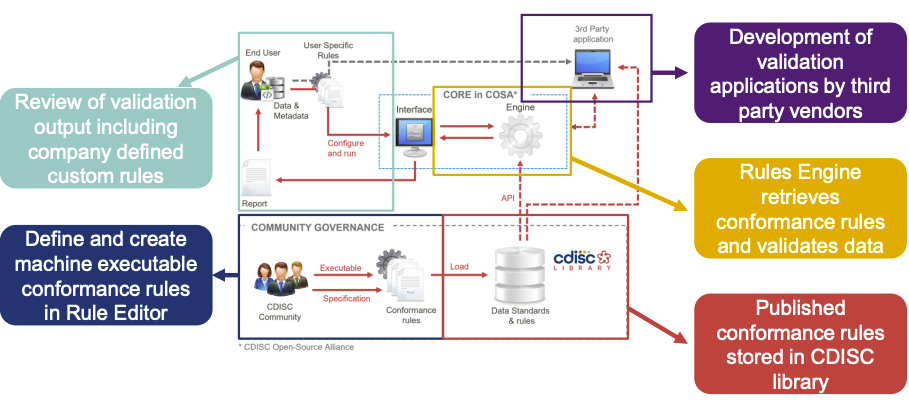

**Using the CORE Engine**

As seen throughout this notebook demonstration, the CDISC CORE Engine can be used to run Conformance Rules from the CDISC Library to validate the SDTM Trial Design Domains.  A validation report is created for any validation executed by the CORE Engine.

Once installed, the CORE rules local cache can be updated with the latest rules available in the CDISC Library.  In order to update the local CORE engine rules cache, the environmental parameter CDISC_API_KEY must exist.

Use the command `python core.py update-cache --apikey CDISC_API_KEY`

A full list of available core validate rule sets can be displayed using the command-line utility.

In [86]:
# @title
# Display a list of rule sets available in CORE

change_working_dir(os.path.join(WORKING_DIR, 'core'))
!./core list-rule-sets

INFO: Already in the /content/core project directory...
pkg_resources/__init__.py:2211: UserWarning: /content/core/._cryptography-3.4.8.egg-info could not be properly decoded in UTF-8
pkg_resources/__init__.py:2211: UserWarning: /content/core/._wheel-0.37.1.egg-info could not be properly decoded in UTF-8
ADAMIG, 1-0
ADAMIG, 1-1
ADAMIG, 1-2
ADAMIG, 1-3
SDTMIG, 3-2
SDTMIG, 3-3
SDTMIG, 3-4
SENDIG, 3-0
SENDIG, 3-1
SENDIG, 3-1-1
SENDIG-AR, 1-0
SENDIG-DART, 1-1
SENDIG-DART, 1-2
SENDIG-GENETOX, 1-0
TIG, 1-0
TIG, 1-0/sdtm
TIG, 1-0/send
USDM, 3-0
USDM, 4-0


Multiple CDISC standards and corresponding Conformance Rule sets are available.  We have used the SDTMIG, 3-4 Conformance Rules for our Trial Design Datasets as well as the Vital Signs dataset.

For additional commands, use the help page.

In [87]:
# @title
# Display help text

!./core --help

pkg_resources/__init__.py:2211: UserWarning: /content/core/._cryptography-3.4.8.egg-info could not be properly decoded in UTF-8
pkg_resources/__init__.py:2211: UserWarning: /content/core/._wheel-0.37.1.egg-info could not be properly decoded in UTF-8
Usage: core [OPTIONS] COMMAND [ARGS]...

Options:
  --help  Show this message and exit.

Commands:
  list-ct                Command to list the ct packages available in the...
  list-dataset-metadata  Command that lists metadata of given datasets.
  list-rule-sets         Lists all standards and versions for which rules...
  list-rules
  test-validate          **Release Test** validate command for executable.
  update-cache
  validate               Validate data using CDISC Rules Engine
  version


Add additional command-line arguments to --help to see options and parameters available for a certain command.

`./core validate --help`

**Validate the USDM JSON file against the conformance rules defined in the CDISC Rules Engine**

This conformance report was also generated when we first uploaded the USDM JSON file.

This command is executed directly against the USDM JSON file in the Operational Data Store.

In [88]:
# @title
# Validate the USDM JSON file against the USDM version 4 Conformance Rules

destination_path = os.path.join(REPORT_DIR, 'usdm_validation_results')
print(usdm_file_path)
!./core validate -s USDM -v 4-0 -o {destination_path} -dp {usdm_file_path}

/content/drive/MyDrive/TMF/H2Q-MC-LZZT/protocol/pilot_LLZT_protocol.json
pkg_resources/__init__.py:2211: UserWarning: /content/core/._cryptography-3.4.8.egg-info could not be properly decoded in UTF-8
pkg_resources/__init__.py:2211: UserWarning: /content/core/._wheel-0.37.1.egg-info could not be properly decoded in UTF-8
  [████████████████████████████████████]  100%
Output: /content/drive/MyDrive/TMF/H2Q-MC-LZZT/reports/usdm_validation_results


### Working with the Conformance Report

Executing the CORE engine conformance rules will generate a report summarizing all executed rules and detailiing any failures for the study team to address.

In [89]:
# @title
# View the Rules Report worksheet in the report produced by the CORE Engine

results_file = destination_path + '.xlsx'
df = pd.read_excel(results_file, sheet_name='Rules Report')
display(df)

CORE-ID  Version CDISC RuleID  FDA RuleID  \
0           NaN        1     DDF00156         NaN   
1   CORE-000402        1     DDF00006         NaN   
2   CORE-000403        1     DDF00007         NaN   
3   CORE-000404        1     DDF00008         NaN   
4   CORE-000408        1     DDF00013         NaN   
5   CORE-000414        1     DDF00021         NaN   
6   CORE-000416        1     DDF00023         NaN   
7   CORE-000417        1     DDF00025         NaN   
8   CORE-000419        1     DDF00027         NaN   
9   CORE-000423        1     DDF00031         NaN   
10  CORE-000424        1     DDF00032         NaN   
11  CORE-000427        1     DDF00035         NaN   
12  CORE-000428        1     DDF00036         NaN   
13  CORE-000449        1     DDF00040         NaN   
14  CORE-000804        1     DDF00046         NaN   
15  CORE-000805        1     DDF00042         NaN   
16  CORE-000806        1     DDF00017         NaN   
17  CORE-000807        1     DDF00037         NaN   
18  CORE-000808        1     DDF00073         NaN   
19  CORE-000809        1     DDF00047         NaN   
20  CORE-000810        1     DDF00075         NaN   
21  CORE-000811        1     DDF00090         NaN   
22  CORE-000812        1     DDF00014         NaN   
23  CORE-000813        1     DDF00052         NaN   
24  CORE-000814        1     DDF00094         NaN   
25  CORE-000815        1     DDF00097         NaN   
26  CORE-000816        1     DDF00099         NaN   
27  CORE-000817        1     DDF00100         NaN   
28  CORE-000818        1     DDF00026         NaN   
29  CORE-000819        1     DDF00102         NaN   
30  CORE-000820        1     DDF00060         NaN   
31  CORE-000821        1     DDF00044         NaN   
32  CORE-000822        1     DDF00108         NaN   
33  CORE-000823        1     DDF00115         NaN   
34  CORE-000824        1     DDF00019         NaN   
35  CORE-000825        1     DDF00061         NaN   
36  CORE-000826        1     DDF00062         NaN   
37  CORE-000827        1     DDF00127         NaN   
38  CORE-000828        1     DDF00063         NaN   
39  CORE-000829        1     DDF00054         NaN   
40  CORE-000830        1     DDF00011         NaN   
41  CORE-000831        1     DDF00058         NaN   
42  CORE-000832        1     DDF00059         NaN   
43  CORE-000833        1     DDF00137         NaN   
44  CORE-000834        1     DDF00151         NaN   
45  CORE-000835        1     DDF00071         NaN   
46  CORE-000836        1     DDF00072         NaN   
47  CORE-000837        1     DDF00028         NaN   
48  CORE-000838        1     DDF00029         NaN   
49  CORE-000839        1     DDF00024         NaN   
50  CORE-000840        1     DDF00152         NaN   
51  CORE-000849        1     DDF00022         NaN   
52  CORE-000851        1     DDF00018         NaN   

                                              Message   Status  
0   The environmental settings of the encounter ar...  SUCCESS  
1   One or more of the window attributes (windowLa...  SUCCESS  
2   The Timing type is "Fixed Reference" but it do...  SUCCESS  
3   The defaultConditionId and timelineExitId attr...  SUCCESS  
4   A required biomedical concept property (isRequ...  SUCCESS  
5   An instance of a class is referencing itself a...  SUCCESS  
6   The next and previous relationships are not re...  SUCCESS  
7   One or more of the window attributes (windowLa...  SUCCESS  
8   The same instance is referenced more than once...  SUCCESS  
9   The Timing type is not "Fixed Reference" but i...  SUCCESS  
10  The business therapeutic areas of the study ve...  SUCCESS  
11  There is not a one-to-one relationship between...  SUCCESS  
12  Type is "Fixed Reference" for the timing but r...  SUCCESS  
13  The study element is not referenced by any stu...  SUCCESS  
14  The relative to/from scheduled instance of a t...  SUCCESS  
15  The planned age range is marked as approximate...  SUCCESS  
16  The unit for a subject enrollement q

In [90]:
# @title
# View the Issue Summary worksheet in the report produced by the CORE Engine
df = pd.read_excel(results_file, sheet_name='Issue Summary')
display(df)

Dataset      CORE-ID  \
0  Activity.json  CORE-000810   
1      Code.json  CORE-000427   

                                             Message  Issues  Explanation  
0  The activity does not refer to any procedure, ...      12          NaN  
1  There is not a one-to-one relationship between...      38          NaN

The Conformance Rules CORE-000810 and CORE-000427 are reporting issues.

In the next section, we will examine these rules in the Conformance Rules Editor to examine how these rules are defined.

### Conformance Rules Editor

The Conformance Rules Editor is used to define rules used to evaluate data sets and study resources against CDISC Standards and Business Rules.

Custom conformance rules can also be created using the Rule Editor.

Rules Editor: https://rule-editor.cdisc.org/

Search for the CORE rule CORE-000810 reported in the validation of the USDM JSON v4.


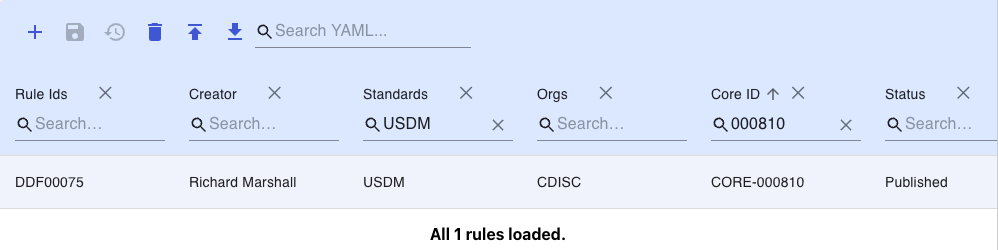

The text editor in the right-hand pane on the Rule Editor shows the YAML text used to define the Conformance Rule.

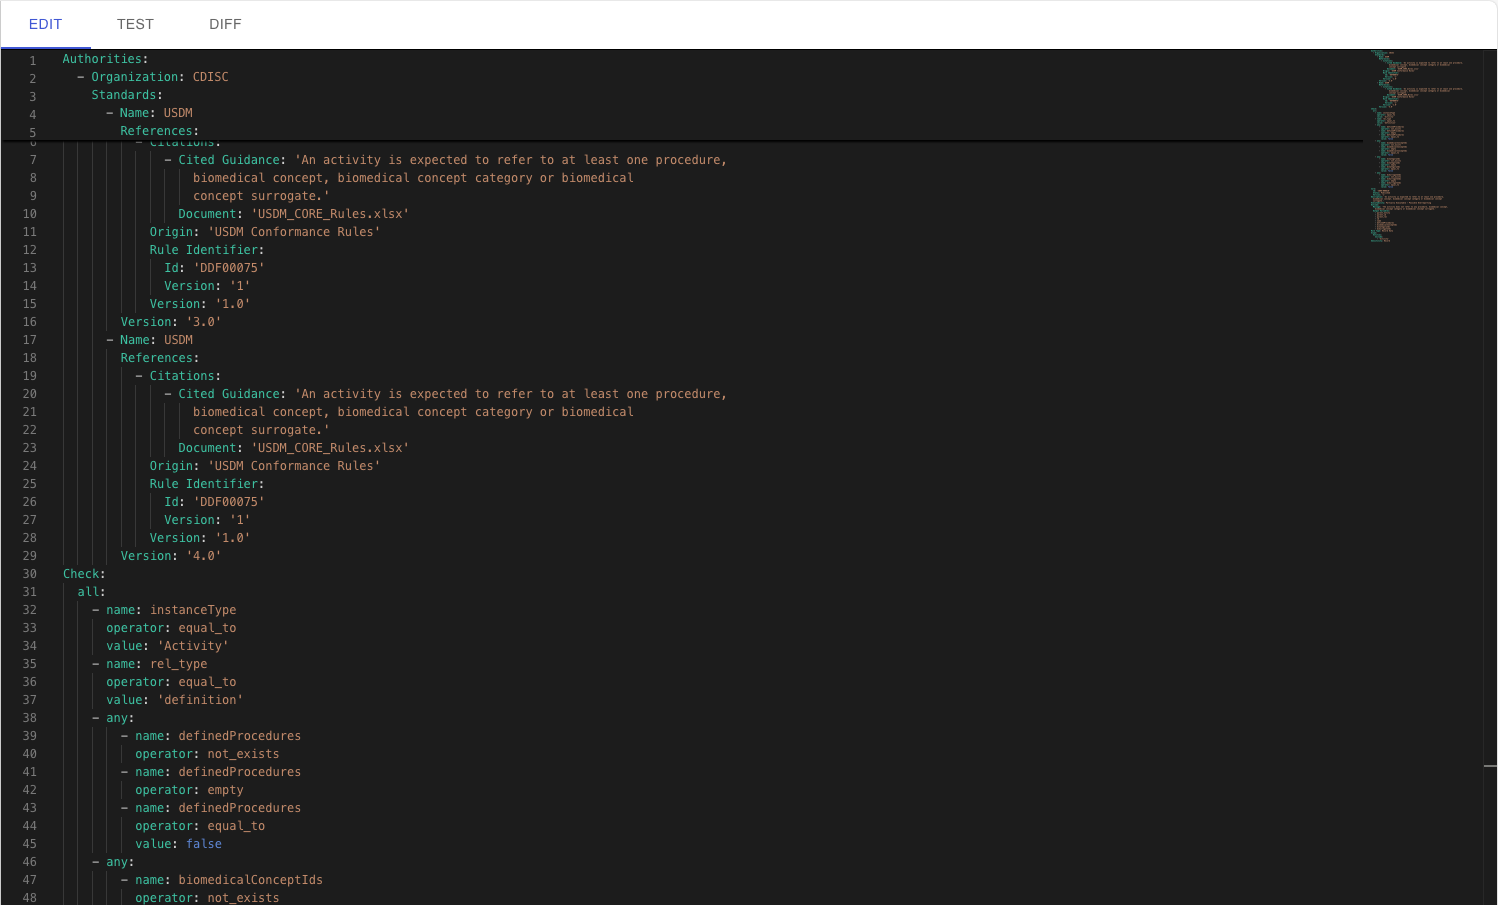

The `Description` and `Message` show the text reported in the CORE report.

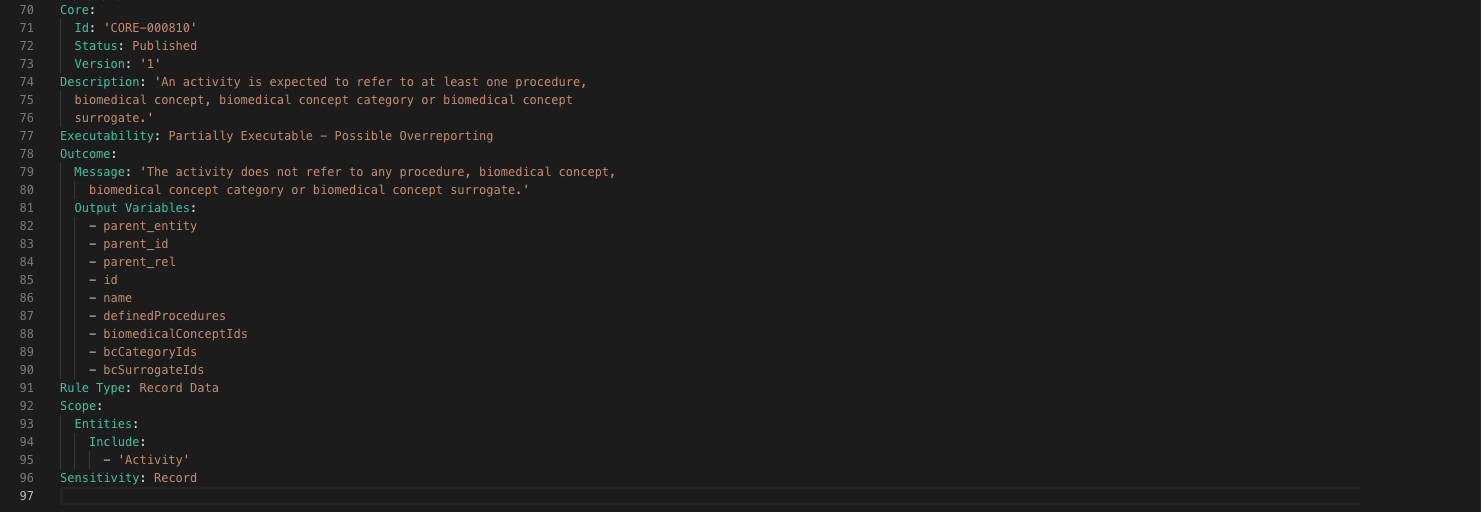

A full lising of rules defined for a standard can be accessed using filtering.

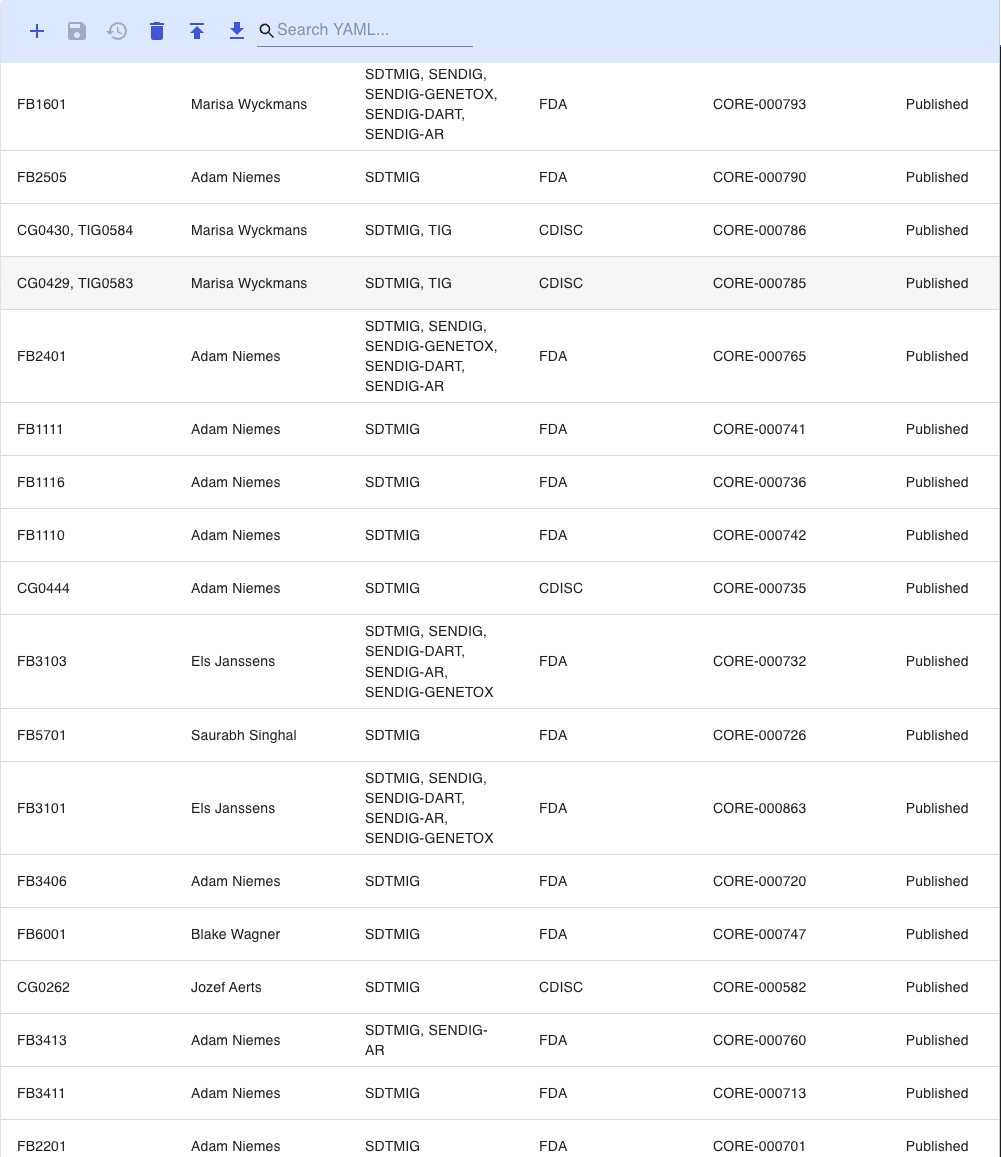

Additonally, a report for the filtered rules can be exported. View a summary of the SDTMIG Conformance Rules executed against the VS.xpt file produced using the sdtm.oak R library.

In [91]:
# Display rules run against VS XPT file
core_report = os.path.join(CONTENT_DIR, "SDTM_CORE_Rules.csv")
df = pd.read_csv(core_report)
df = df[df['Core-ID'].isin(['CORE-000019', 'CORE-000182', 'CORE-000581', 'CORE-000594', 'CORE-000598', 'CORE-000739'])]
df = df[['Core-ID', 'CDISC Rule ID', 'Description', 'Standard Name', 'Standard Version', 'Executability']]
display(df)


Core-ID                        CDISC Rule ID  \
21   CORE-000581  CG0368, TIG0532, TRC1736a, TRC1736c   
46   CORE-000594     CG0359, SEND29, TIG0524, TIG0205   
157  CORE-000739                               CG0407   
355  CORE-000598      CG0413, TIG0568, SEND1, TIG0037   
408  CORE-000182      CG0310, SEND2, TIG0485, TIG0128   
412  CORE-000019      CG0311, SEND3, TIG0486, TIG0211   

                                           Description  \
21       Raise an error when DM dataset is not present   
46   Raise an error when a variable label is not in...   
157  Trigger error when study includes protocol-spe...   
355  The dataset name must begin with the DOMAIN va...   
408  Raise an error when variable name length is gr...   
412  Raise and error if Variable label length > 40 ...   

                                         Standard Name  \
21   SDTMIG, TIG, SENDIG, SENDIG-GENETOX, SENDIG-DA...   
46    SDTMIG, SENDIG, SENDIG-DART, SENDIG-GENETOX, TIG   
157                                             SDTMIG   
355   SDTMIG, TIG, SENDIG, SENDIG-DART, SENDIG-GENETOX   
408   SDTMIG, SENDIG, SENDIG-DART, SENDIG-GENETOX, TIG   
412   SDTMIG, SENDIG, SENDIG-DART, SENDIG-GENETOX, TIG   

                                  Standard Version     Executability  
21   3.4, 3.2, 3.3, 1.0, 3.0, 3.1, 3.1.1, 1.1, 1.2  Fully Executable  
46   3.4, 3.2, 3.3, 3.0, 3.1, 3.1.1, 1.1, 1.2, 1.0  Fully Executable  
157                                  3.4, 3.2, 3.3  Fully Executable  
355  3.4, 3.2, 3.3, 1.0, 3.0, 3.1, 3.1.1, 1.1, 1.2  Fully Executable  
408  3.4, 3.2, 3.3, 3.1.1, 3.1, 3.0, 1.1, 1.2, 1.0  Fully Executable  
412  3.4, 3.2, 3.3, 3.1, 3.1.1, 3.0, 1.1, 1.2, 1.0  Fully Executable

Summary information is presented for the subset of the SDTMIG Conformance Rules executed against the VS domain XPT file generated using the {sdtm.oak} library.



---



## Summary

The 360i initiative has led to the creation of many open-source projects contributing to automating the study processes of Digital Protocol to SDTM submission.

The CDISC Pilot Study is defined in an XLSX notebook and used to create the USDM JSON study design through the Study Definitions Workbench. This USDM becomes an input for all downstream processes.

From the USDM, CRFs and annotated CRFs are created in ODM, JSON and HTML format for use as study assets and import into EDC systems.

The USDM is used to create SDTM Trial Design Domains, the Define-XML and empty SDTM domain shell data sets.

Raw clinical data is used in conjunction with the \{sdtm.oak} R library to generate R scripts used to create SDTM domains.

Throughout the noteboook, the CDISC CORE Rules engine is used to confirm standards conformance using the rules defined in the CDISC Library.

All conformant assets are stored in the Object Store to ensure backup, accountability and traceability in a single repository.  All tabular data used and created throughout the notebook are stored in the Relational Database.



---



## Cleanup

Use the cleanup cell below to remove all assets created during execution of this notebook.

In [92]:
print(WORKING_DIRS)

['/content/cdisc-json-validation', '/content/core', '/content/cdisc360i-pocs', '/content/cdisc-usdm-utils', '/content/360i', '/content/template2define']


In [94]:
# Cleanup the working directory
change_working_dir(WORKING_DIR)
print("INFO: Removing working directories...")

for dir in WORKING_DIRS:
  if os.path.exists(dir):
    print("INFO: Removing {}...".format(dir))
    shutil.rmtree(dir)

if os.path.exists('core.tar.gz'):
  print("INFO: Removing core.tar.gz...")
  os.remove('core.tar.gz')

if os.path.exists(os.path.join(DATABASE_DIR, 'ods.db')):
  print("INFO: Removing the working directory database...")
  os.remove(os.path.join(DATABASE_DIR, 'ods.db'))

if os.path.exists(xlsx_file_path):
  print("INFO: Removing the input XLSX file...")
  os.remove(xlsx_file_path)

if os.path.exists(usdm_file_path):
  print("INFO: Removing the output USDM file...")
  os.remove(usdm_file_path)

INFO: Already in the /content project directory...
INFO: Removing working directories...
INFO: Removing the input XLSX file...
INFO: Removing the output USDM file...


In [ ]:
exit(0)